In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

import networkx as nx

from scipy.spatial import distance

# Load the data from both modalities

In [2]:
%%time
rna_cna = pd.read_csv("../data/interim/FRP_copykat_CNA_results.txt", sep = "\t", index_col = 2)
rna_anno = pd.read_csv("../data/interim/FRP_copykat_CNA_raw_results_gene_by_cell.txt", sep = "\t",usecols = [0, 1, 2,3,4,5], index_col = 0)

CPU times: user 1min 59s, sys: 4.11 s, total: 2min 3s
Wall time: 2min 3s


In [3]:
rna_anno.head()

chromosome_name  start_position  end_position  ensembl_gene_id  \
abspos                                                                   
934254                1          923928        944581  ENSG00000187634   
951756                1          944204        959309  ENSG00000188976   
963151                1          960587        965715  ENSG00000187961   
971181                1          966497        975865  ENSG00000187583   
999567                1          998962       1000172  ENSG00000188290   

       hgnc_symbol  
abspos              
934254      SAMD11  
951756       NOC2L  
963151      KLHL17  
971181     PLEKHN1  
999567        HES4

In [4]:
chroms = rna_cna.chrom

In [5]:
rna_cna = rna_cna.drop(columns = ["chrom","chrompos"])


In [6]:
rna_cna.head()

AAACAAGCAAACGGGA.1  AAACAAGCAAATAGGA.1  AAACAAGCAACAAGTT.1  \
abspos                                                                  
1042457.0           -0.036124           -0.093622            0.098105   
1265484.0           -0.036124           -0.093622            0.098105   
1519859.0           -0.036124           -0.093622            0.098105   
1826619.0           -0.036124           -0.093622            0.098105   
2058465.0            0.008697           -0.135474            0.023012   

           AAACAAGCAACCATTC.1  AAACAAGCAACTAAAC.1  AAACAAGCAAGTCGCG.1  \
abspos                                                                  
1042457.0            0.159482            0.113863            0.049553   
1265484.0            0.159482            0.113863            0.049553   
1519859.0            0.159482            0.113863            0.049553   
1826619.0            0.159482            0.113863            0.049553   
2058465.0           -0.000307           -0.153787           -0.000637   

           AAACAAGCAATACCCT.1  AAACAAGCAATGGGAG.1  AAACAAGCACAAGCGT.1  \
abspos                                                                  
1042457.0            0.024992           -0.055088            0.063074   
1265484.0            0.024992           -0.055088            0.063074   
1519859.0            0.024992           -0.055088            0.063074   
1826619.0            0.024992           -0.055088            0.063074   
2058465.0            0.000069            0.000235           -0.059653   

           AAACAAGCACATTGTC.1  ...  TTTGGCGGTTTACGAC.1  TTTGGCGGTTTGTGAC.1  \
abspos                         ...                                           
1042457.0            0.073035  ...            0.105740           -0.044175   
1265484.0            0.073035  ...            0.105740           -0.044175   
1519859.0            0.073035  ...            0.105740           -0.044175   
1826619.0            0.073035  ...            0.105740           -0.044175   
2058465.0            0.000031  ...            0.040347           -0.016430   

           TTTGTGAGTAAAGCAT.1  TTTGTGAGTACTTAGC.1  TTTGTGAGTCCGTGAC.1  \
abspos                                                                  
1042457.0           -0.015850            0.061139            0.040408   
1265484.0           -0.015850            0.061139            0.040408   
1519859.0           -0.015850            0.061139            0.040408   
1826619.0           -0.015850            0.061139            0.040408   
2058465.0           -0.184834           -0.150781            0.043961   

           TTTGTGAGTGATAAAC.1  TTTGTGAGTGGTTACT.1  TTTGTGAGTTACTTCT.1  \
abspos                                                                  
1042457.0            0.084354           -0.110451            0.106061   
1265484.0            0.084354           -0.110451            0.106061   
1519859.0            0.084354           -0.110451            0.106061   
1826619.0            0.084354           -0.110451            0.106061   
2058465.0            0.000039           -0.021113           -0.134849   

           TTTGTGAGTTGTCATA.1  TTTGTGAGTTTGGCCA.1  
abspos                                             
1042457.0            0.054095           -0.051687  
1265484.0            0.054095           -0.051687  
1519859.0            0.054095           -0.051687  
1826619.0            0.054095           -0.051687  
2058465.0            0.024735           -0.044809  

[5 rows x 24954 columns]

In [7]:
rna_anno["abspos"] = rna_anno.index

In [8]:
vis_cna = pd.read_csv("../data/interim/visium__copykat_CNA_results.txt", sep = "\t", index_col = 2)
vis_anno = pd.read_csv("../data/interim/visium__copykat_CNA_raw_results_gene_by_cell.txt", sep = "\t",usecols = [0, 1, 2,3,4,5], index_col = 0)


In [9]:
vis_cna.head()

chrom  chrompos  AACACCTACTATCGAA.1  AACACGTGCATCGCAC.1  \
abspos                                                               
1042457.0      1   1042457           -0.091049            0.153342   
1265484.0      1   1265484           -0.091049            0.153342   
1519859.0      1   1519859           -0.091049            0.153342   
1826619.0      1   1826619           -0.054757            0.000087   
2058465.0      1   2058465           -0.054757            0.000087   

           AACACTTGGCAAGGAA.1  AACAGGAAGAGCATAG.1  AACAGGATTCATAGTT.1  \
abspos                                                                  
1042457.0            0.049655           -0.035673            0.067956   
1265484.0            0.049655           -0.035673            0.067956   
1519859.0            0.049655           -0.035673            0.067956   
1826619.0           -0.000228            0.026224            0.000067   
2058465.0           -0.000228            0.026224            0.000067   

           AACAGGCCAACGATTA.1  AACAGGTTATTGCACC.1  AACAGGTTCACCGAAG.1  ...  \
abspos                                                                 ...   
1042457.0           -0.000013           -0.062159            0.033409  ...   
1265484.0           -0.000013           -0.062159            0.033409  ...   
1519859.0           -0.000013           -0.062159            0.033409  ...   
1826619.0           -0.034932            0.000142           -0.084762  ...   
2058465.0           -0.034932            0.000142           -0.084762  ...   

           TGTTCGCAACCGCCAA.1  TGTTCGTGACCAGTAG.1  TGTTCTGCTCTGTCGT.1  \
abspos                                                                  
1042457.0            0.074535            0.094102            0.062220   
1265484.0            0.074535            0.094102            0.062220   
1519859.0            0.074535            0.094102            0.062220   
1826619.0            0.090684            0.000242           -0.037012   
2058465.0            0.090684            0.000242           -0.037012   

           TGTTGCGTCCAAGATT.1  TGTTGGAACCTTCCGC.1  TGTTGGAACGAGGTCA.1  \
abspos                                                                  
1042457.0           -0.086114           -0.024866           -0.000140   
1265484.0           -0.086114           -0.024866           -0.000140   
1519859.0           -0.086114           -0.024866           -0.000140   
1826619.0           -0.025419           -0.017842            0.067158   
2058465.0           -0.025419           -0.017842            0.067158   

           TGTTGGAAGCTCGGTA.1  TGTTGGATGGACTTCT.1  TGTTGGCCAGACCTAC.1  \
abspos                                                                  
1042457.0            0.064452           -0.049732            0.000383   
1265484.0            0.064452           -0.049732            0.000383   
1519859.0            0.064452           -0.049732            0.000383   
1826619.0           -0.052614           -0.076896            0.000383   
2058465.0           -0.052614           -0.076896            0.000383   

           TGTTGGCCTACACGTG.1  
abspos                         
1042457.0           -0.036065  
1265484.0           -0.036065  
1519859.0           -0.036065  
1826619.0            0.047685  
2058465.0            0.047685  

[5 rows x 4974 columns]

In [10]:
vis_cna = vis_cna.drop(columns = ["chrom","chrompos"])

In [11]:
vis_cna.shape

(12167, 4972)

In [12]:
rna_cna.shape

(12167, 24954)

In [13]:
vis_cna = vis_cna.T
rna_cna = rna_cna.T

In [14]:
rna_cna.index = [x.replace(".","-") for x in rna_cna.index]

In [15]:
vis_cna.index = [x.replace(".","-") for x in vis_cna.index]

# Clustering

## Filtering

In [16]:
rna_var = rna_cna.std(axis = 1)

In [17]:
rna_cell_anno = pd.read_csv("../data/interim/FRP_copykat_prediction.txt", sep = "\t", index_col = 0)

In [18]:
rna_var.name = "variance"

In [19]:
rna_var

AAACAAGCAAACGGGA-1    0.021886
AAACAAGCAAATAGGA-1    0.046243
AAACAAGCAACAAGTT-1    0.027815
AAACAAGCAACCATTC-1    0.043006
AAACAAGCAACTAAAC-1    0.093684
                        ...   
TTTGTGAGTGATAAAC-1    0.020027
TTTGTGAGTGGTTACT-1    0.043180
TTTGTGAGTTACTTCT-1    0.079635
TTTGTGAGTTGTCATA-1    0.037912
TTTGTGAGTTTGGCCA-1    0.034928
Name: variance, Length: 24954, dtype: float64

In [20]:
rna_cell_anno

copykat.pred
cell.names                     
AAACAAGCAAACGGGA-1      diploid
AAACAAGCAAATAGGA-1    aneuploid
AAACAAGCAACAAGTT-1      diploid
AAACAAGCAACCATTC-1      diploid
AAACAAGCAACTAAAC-1    aneuploid
...                         ...
TTTGTGAGTGGTTACT-1  not.defined
TTTGTGAGTGTTCCAG-1  not.defined
TTTGTGAGTTACTTCT-1  not.defined
TTTGTGAGTTGTCATA-1  not.defined
TTTGTGAGTTTGGCCA-1  not.defined

[54958 rows x 1 columns]

In [21]:
rna_cell_anno = rna_cell_anno.merge(rna_var, right_index=True, left_index=True)

In [22]:
rna_cell_anno = rna_cell_anno.sort_values(by = "variance", ascending = False)

In [23]:
rna_cell_anno["id"] = np.arange(0, len(rna_cell_anno))

In [24]:
rna_cell_anno

copykat.pred  variance     id
cell.names                                      
CGCAAGGGTTAGTGAG-1    aneuploid  0.158918      0
CGCAAGGGTTAGTGAG-1  not.defined  0.158918      1
CAAGACTAGCTTGAGG-1  not.defined  0.139916      2
CAAGACTAGCTTGAGG-1    aneuploid  0.139916      3
GCCAATACATTGCCTG-1    aneuploid  0.136529      4
...                         ...       ...    ...
CCAATTTAGACTCAAA-1      diploid  0.015100  49613
ACCAACTGTCGTTCTC-1  not.defined  0.014065  49614
ACCAACTGTCGTTCTC-1      diploid  0.014065  49615
GAGGTCCAGTCAACAA-1  not.defined  0.013988  49616
GAGGTCCAGTCAACAA-1      diploid  0.013988  49617

[49618 rows x 3 columns]

<Axes: xlabel='id', ylabel='variance'>

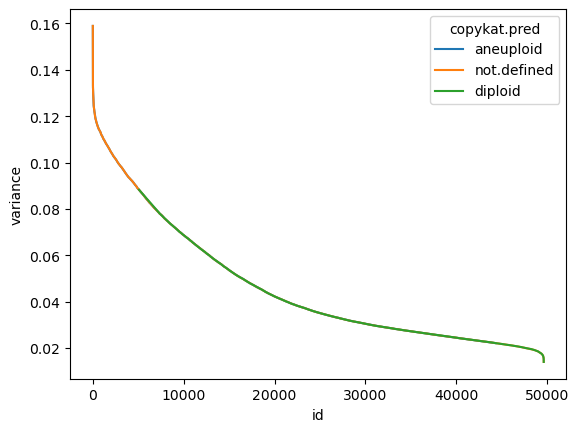

In [25]:
sns.lineplot(data = rna_cell_anno, y = "variance", hue = "copykat.pred", x = "id")

<Axes: xlabel='id', ylabel='variance'>

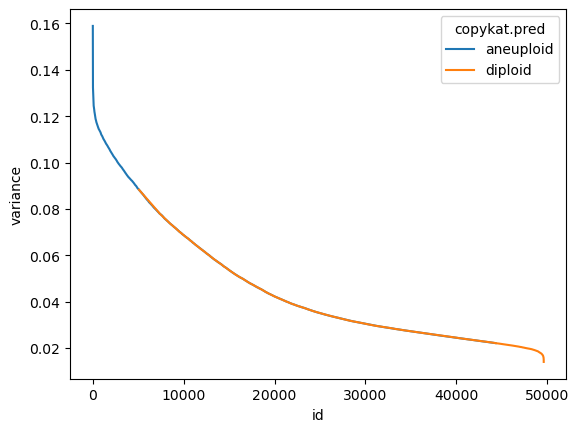

In [26]:
sns.lineplot(data = rna_cell_anno[rna_cell_anno["copykat.pred"]!="not.defined"]
, y = "variance", hue = "copykat.pred", x = "id")

In [27]:
tumor_cells_rna = rna_cell_anno[(rna_cell_anno["copykat.pred"]!="not.defined") & (rna_cell_anno.variance >= 0.04)].index

In [28]:
vis_var = vis_cna.std(axis = 1)

In [29]:
vis_var

AACACCTACTATCGAA-1    0.039785
AACACGTGCATCGCAC-1    0.035591
AACACTTGGCAAGGAA-1    0.053889
AACAGGAAGAGCATAG-1    0.032849
AACAGGATTCATAGTT-1    0.034239
                        ...   
TGTTGGAACGAGGTCA-1    0.039637
TGTTGGAAGCTCGGTA-1    0.051604
TGTTGGATGGACTTCT-1    0.086889
TGTTGGCCAGACCTAC-1    0.037005
TGTTGGCCTACACGTG-1    0.041668
Length: 4972, dtype: float64

In [30]:
vis_cell_anno = pd.read_csv("../data/interim/visium__copykat_prediction.txt", sep = "\t", index_col = 0)

In [31]:
vis_cell_anno

copykat.pred
cell.names                     
AACACCTACTATCGAA-1      diploid
AACACGTGCATCGCAC-1      diploid
AACACTTGGCAAGGAA-1      diploid
AACAGGAAGAGCATAG-1      diploid
AACAGGATTCATAGTT-1      diploid
...                         ...
TGTTGGAACGAGGTCA-1  not.defined
TGTTGGAAGCTCGGTA-1  not.defined
TGTTGGATGGACTTCT-1  not.defined
TGTTGGCCAGACCTAC-1  not.defined
TGTTGGCCTACACGTG-1  not.defined

[9664 rows x 1 columns]

In [32]:
vis_var.name = "variance"

In [33]:
vis_cell_anno = vis_cell_anno.merge(vis_var, right_index=True, left_index=True)

In [34]:
vis_cell_anno = vis_cell_anno.sort_values(by = "variance", ascending = False)

In [35]:
vis_cell_anno["id"] = np.arange(0, len(vis_cell_anno))

<Axes: xlabel='id', ylabel='variance'>

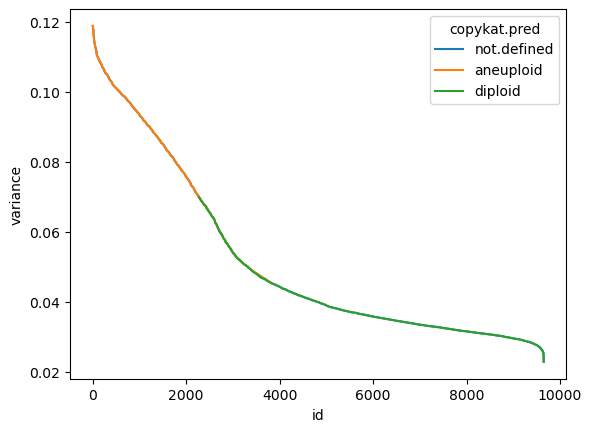

In [36]:
sns.lineplot(data = vis_cell_anno, y = "variance", hue = "copykat.pred", x = "id")

<Axes: xlabel='id', ylabel='variance'>

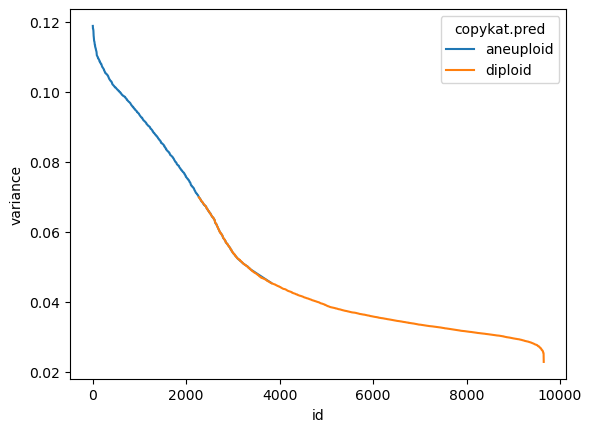

In [37]:
sns.lineplot(data = vis_cell_anno[vis_cell_anno["copykat.pred"]!="not.defined"]
, y = "variance", hue = "copykat.pred", x = "id")

In [38]:
tumor_cells_vis = vis_cell_anno[(vis_cell_anno["copykat.pred"]!="not.defined") & (vis_cell_anno.variance >= 0.04)].index

In [39]:
vis_cell_anno["tumor"] = vis_cell_anno.variance >= 0.04

In [40]:
rna_cell_anno["tumor"] = rna_cell_anno.variance >= 0.04

In [41]:
vis_cna = vis_cna.loc[tumor_cells_vis]

In [42]:
rna_cna = rna_cna.loc[tumor_cells_rna]

## Visium

In [43]:
adata_vis = sc.AnnData(vis_cna)


/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [45]:
num_comp = 70
sc.tl.pca(adata_vis, svd_solver='arpack', n_comps = num_comp)

In [46]:
print(np.cumsum(adata_vis.uns["pca"]['variance_ratio'])[-1])


0.8987444642162841


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


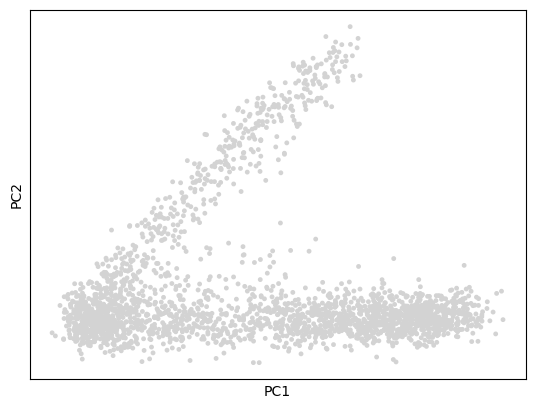

/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


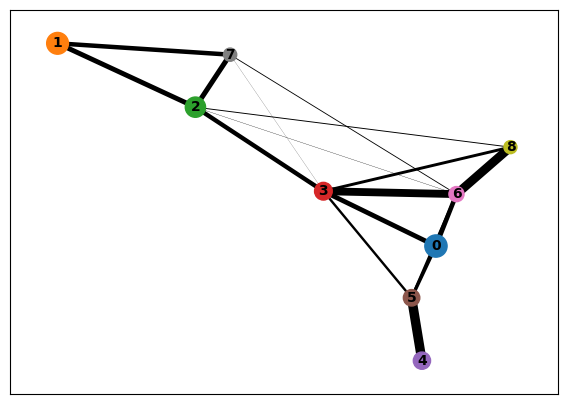

In [47]:
sc.pl.pca(adata_vis)
sc.pp.neighbors(adata_vis, n_pcs=num_comp)
sc.tl.leiden(adata_vis)
sc.tl.paga(adata_vis)
sc.pl.paga(adata_vis, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_vis, init_pos='paga')


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


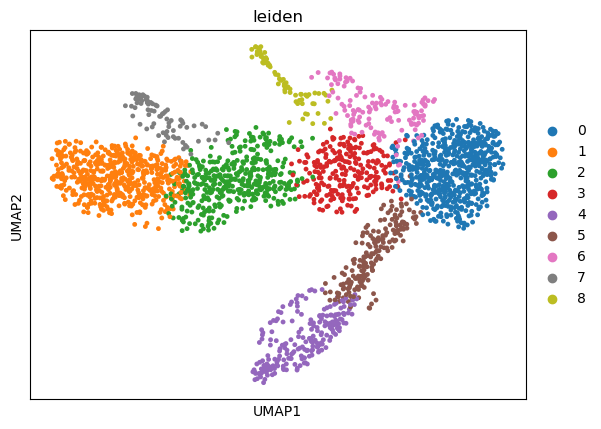

In [48]:
sc.pl.umap(adata_vis, color = "leiden")

In [49]:
adata_vis.X

array([[ 7.46090631e-02,  7.46090631e-02,  7.46090631e-02, ...,
         3.02384991e-02,  3.02384991e-02,  3.02384991e-02],
       [-6.13387055e-02, -6.13387055e-02, -6.13387055e-02, ...,
        -2.28719341e-05, -2.28719341e-05, -2.28719341e-05],
       [ 7.33012594e-02,  7.33012594e-02,  7.33012594e-02, ...,
        -2.28387369e-02, -2.28387369e-02, -2.28387369e-02],
       ...,
       [-2.81186962e-02, -2.81186962e-02, -2.81186962e-02, ...,
         5.53641487e-02,  5.53641487e-02,  5.53641487e-02],
       [ 7.59207775e-02,  7.59207775e-02,  7.59207775e-02, ...,
        -1.23408403e-04, -1.23408403e-04, -1.23408403e-04],
       [ 5.72004247e-02,  5.72004247e-02,  5.72004247e-02, ...,
        -3.50863779e-02, -3.50863779e-02, -3.50863779e-02]])

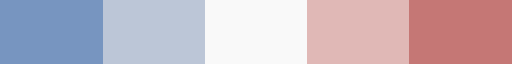

In [50]:
newcmp = list(sns.color_palette("vlag",5))
newcmp[2] = "#F9F9F9"
newcmp = ListedColormap(newcmp)   
newcmp

In [51]:
clones_vis = adata_vis.obs["leiden"]

In [52]:
#change data type of clones_vis to int
clones_vis = clones_vis.astype(int)

In [53]:
lut_vis = dict(zip(clones_vis.unique(), sns.color_palette("Set1", len(clones_vis.unique()))))

In [54]:
row_colors_vis = clones_vis.map(lut_vis)

In [55]:
tmp_vis = pd.DataFrame(adata_vis.X)
tmp_vis.index = adata_vis.obs.index


In [56]:
tmp_vis = tmp_vis.loc[clones_vis.sort_values().index]

In [57]:
vis_anno

chromosome_name  start_position  end_position  ensembl_gene_id   
abspos                                                                       
934254                    1          923928        944581  ENSG00000187634  \
951756                    1          944204        959309  ENSG00000188976   
963151                    1          960587        965715  ENSG00000187961   
971181                    1          966497        975865  ENSG00000187583   
999567                    1          998962       1000172  ENSG00000188290   
...                     ...             ...           ...              ...   
3030219934               23       155197007     155239817  ENSG00000155959   
3030262937               23       155258241     155264589  ENSG00000155961   
3030306956               23       155276211     155334657  ENSG00000155962   
3030581551               23       155490115     155669944  ENSG00000185973   
3030914053               23       155881293     155943769  ENSG00000124333   

           hgnc_symbol  
abspos                  
934254          SAMD11  
951756           NOC2L  
963151          KLHL17  
971181         PLEKHN1  
999567            HES4  
...                ...  
3030219934        VBP1  
3030262937      RAB39B  
3030306956       CLIC2  
3030581551       TMLHE  
3030914053       VAMP7  

[11241 rows x 5 columns]

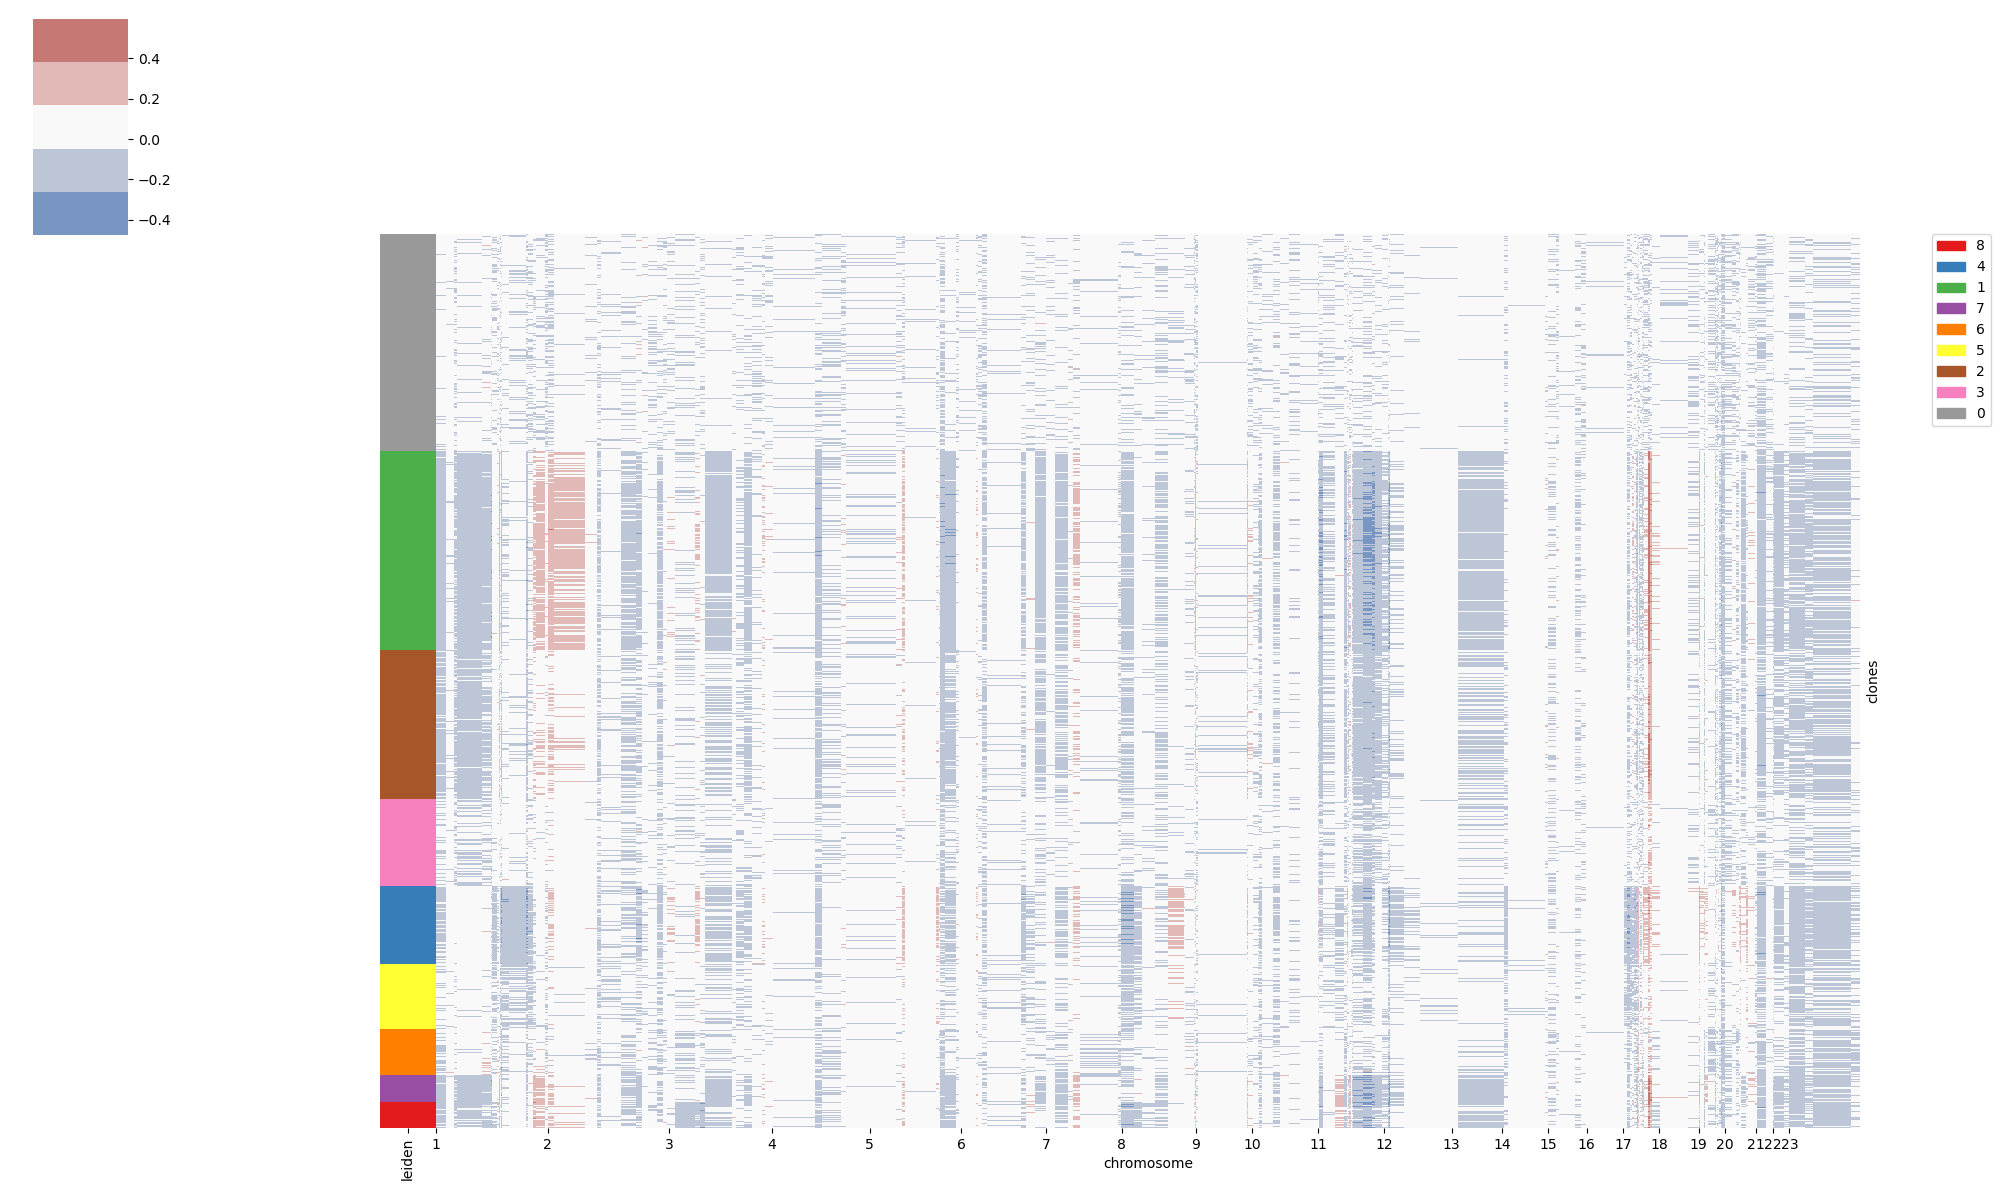

In [58]:
g = sns.clustermap(tmp_vis, row_colors = row_colors_vis, cmap = newcmp, figsize = (19,12), xticklabels = False, yticklabels = False,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()

    
handles = [mpatches.Patch(color=lut_vis[key], label=key) for key in lut_vis]
g.ax_heatmap.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [59]:
clones = clones_vis.sort_values().values

In [60]:
cons_vis = []
vis_clone_size = {}
for cl in range(len(set(clones))):
    idx = np.where(clones == cl)[0]
    values = tmp_vis.iloc[idx]
    values = values.median().values
    cons_vis.append(values)
    vis_clone_size[cl] = len(idx)
    

In [61]:
cons_vis = pd.DataFrame(cons_vis, columns = tmp_vis.columns)

In [1]:

g = sns.clustermap(cons_vis, cmap = sns.color_palette("vlag"), figsize = (19,12), xticklabels = False, yticklabels = True,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()




NameError: name 'sns' is not defined

In [63]:
cons = cons_vis.T.copy()
diploid_id = cons.columns[-1]+1
cons[diploid_id] = 0
cons = cons.T
n_clusters = cons.shape[0]
X = np.zeros((n_clusters, n_clusters))
for c1 in range(n_clusters):
    cells1 = cons.loc[c1]
    for c2 in range(n_clusters):

        cells2 =  cons.loc[c2]
        dist = np.linalg.norm(cells1-cells2)
        X[c1,c2] = dist
        if c1 != c2 and dist ==0:
            dist = 1e-06
            X[c1,c2] = dist

In [64]:
X = np.tril(X, -1)
X = csr_matrix(X)
Tcsr = minimum_spanning_tree(X)
tree = Tcsr.toarray().astype(int)

In [65]:
G = nx.Graph()
root = diploid_id

for i in range(np.shape(tree)[0]):
    for j in range(i+1,np.shape(tree)[0]):
        if tree[j,i]>0:
            if i == diploid_id:
                node_i_l = "sudo root"
                node_j_l = f"clone {j}"
            elif j == diploid_id:
                node_j_l = "sudo root"
                node_i_l = f"clone {i}"
            else:
                node_i_l = f"clone {i}"
                node_j_l = f"clone {j}"

            G.add_node(i)
            G.add_node(j)

            G.add_edge(i,j)


#colors = [node_colors.to_dict()[i] for i in G.nodes]
mapping = {x:f"clone {x}" if x !=diploid_id else "pseudo root" for x in G.nodes}
H = nx.relabel_nodes(G, mapping)
pos = hierarchy_pos(H,"pseudo root")  
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw(H,pos, with_labels=True, node_size = 300, ax = ax )

NameError: name 'hierarchy_pos' is not defined

## scRNA

In [66]:
adata_sc = sc.AnnData(rna_cna)


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [67]:
num_comp = 50
sc.tl.pca(adata_sc, svd_solver='arpack', n_comps = num_comp)

In [68]:
print(np.cumsum(adata_sc.uns["pca"]['variance_ratio'])[-1])


0.8810333648078673


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


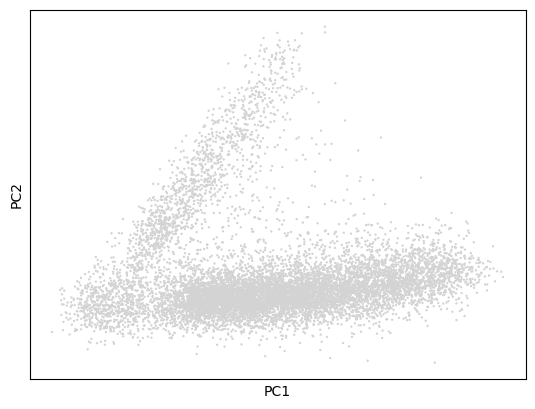

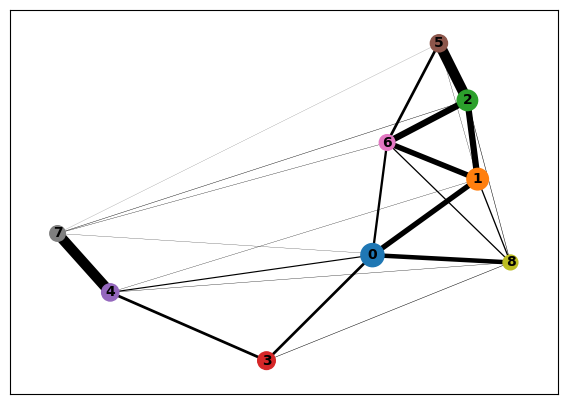

In [69]:
sc.pl.pca(adata_sc)
sc.pp.neighbors(adata_sc, n_pcs=num_comp)
sc.tl.leiden(adata_sc)
sc.tl.paga(adata_sc)
sc.pl.paga(adata_sc, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_sc, init_pos='paga')


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


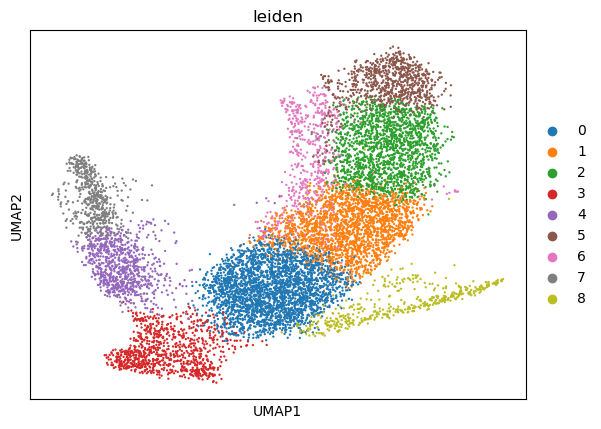

In [70]:
sc.pl.umap(adata_sc, color = "leiden")

In [71]:
clones_sc = adata_sc.obs["leiden"]

In [72]:
#change data type of clones_vis to int
clones_sc = clones_sc.astype(int)

In [73]:
lut_sc = dict(zip(clones_sc.unique(), sns.color_palette("Set2", len(clones_sc.unique()))))

In [74]:
row_colors_sc = clones_sc.map(lut_sc)

In [75]:
tmp_sc = pd.DataFrame(adata_sc.X)
tmp_sc.index = adata_sc.obs.index


In [76]:
tmp_sc = tmp_sc.loc[clones_sc.sort_values().index]

In [77]:
tmp_sc

0         1         2         3         4       
cell.names                                                             
TTACCTTGTATTTACG-1 -0.083031 -0.083031 -0.083031 -0.083031 -0.042781  \
CAACCTTCACTCAAAG-1  0.000050  0.000050  0.000050  0.000050 -0.074802   
CCGCTATAGCCTGGTT-1 -0.119049 -0.119049 -0.119049 -0.119049 -0.026095   
CAGGTAAGTCCTTATT-1 -0.015020 -0.015020 -0.015020 -0.015020 -0.000050   
AGGGACCTCAACCGCT-1 -0.000035 -0.000035 -0.000035 -0.000035 -0.125022   
...                      ...       ...       ...       ...       ...   
GCATTTGTCCTTTAGG-1  0.095806  0.095806  0.095806  0.095806 -0.069932   
ATCCATCCATAGACGC-1  0.087203  0.087203  0.087203  0.087203 -0.182404   
ATTCGATTCACACAAA-1  0.096084  0.096084  0.096084  0.096084 -0.156023   
AAGGCACGTTTGTTTC-1  0.022812  0.022812  0.022812  0.022812  0.027962   
CGCAAGGGTTAGTGAG-1 -0.358088 -0.358088 -0.358088 -0.358088 -0.338997   

                       5         6         7         8         9      ...   
cell.names                                                            ...   
TTACCTTGTATTTACG-1 -0.042781 -0.042781 -0.042781 -0.042781 -0.042781  ...  \
CAACCTTCACTCAAAG-1 -0.074802 -0.074802 -0.074802 -0.074802 -0.074802  ...   
CCGCTATAGCCTGGTT-1 -0.026095 -0.026095 -0.026095 -0.026095 -0.026095  ...   
CAGGTAAGTCCTTATT-1 -0.000050 -0.000050 -0.000050 -0.000050 -0.000050  ...   
AGGGACCTCAACCGCT-1 -0.125022 -0.125022 -0.125022 -0.125022 -0.125022  ...   
...                      ...       ...       ...       ...       ...  ...   
GCATTTGTCCTTTAGG-1 -0.069932 -0.069932 -0.069932 -0.069932 -0.069932  ...   
ATCCATCCATAGACGC-1 -0.182404 -0.182404 -0.182404 -0.182404 -0.182404  ...   
ATTCGATTCACACAAA-1 -0.156023 -0.156023 -0.156023 -0.156023 -0.156023  ...   
AAGGCACGTTTGTTTC-1  0.027962  0.027962  0.027962  0.027962  0.027962  ...   
CGCAAGGGTTAGTGAG-1 -0.338997 -0.338997 -0.338997 -0.338997 -0.338997  ...   

                       12157     12158     12159     12160     12161   
cell.names                                                             
TTACCTTGTATTTACG-1 -0.041230 -0.041230 -0.041230 -0.041230 -0.041230  \
CAACCTTCACTCAAAG-1 -0.024354 -0.024354 -0.024354 -0.024354 -0.024354   
CCGCTATAGCCTGGTT-1 -0.015755 -0.015755 -0.015755 -0.015755 -0.015755   
CAGGTAAGTCCTTATT-1 -0.088729 -0.088729 -0.088729 -0.088729 -0.088729   
AGGGACCTCAACCGCT-1 -0.043676 -0.043676 -0.043676 -0.043676 -0.043676   
...                      ...       ...       ...       ...       ...   
GCATTTGTCCTTTAGG-1 -0.058279 -0.058279 -0.058279 -0.058279 -0.058279   
ATCCATCCATAGACGC-1 -0.053658 -0.053658 -0.053658 -0.053658 -0.053658   
ATTCGATTCACACAAA-1 -0.085728 -0.085728 -0.085728 -0.085728 -0.085728   
AAGGCACGTTTGTTTC-1 -0.023677 -0.023677 -0.023677 -0.023677 -0.023677   
CGCAAGGGTTAGTGAG-1 -0.139933 -0.139933 -0.139933 -0.139933 -0.139933   

                       12162     12163     12164     12165     12166  
cell.names                                                            
TTACCTTGTATTTACG-1 -0.041230 -0.041230 -0.041230 -0.041230 -0.041230  
CAACCTTCACTCAAAG-1 -0.024354 -0.024354 -0.024354 -0.024354 -0.024354  
CCGCTATAGCCTGGTT-1 -0.015755 -0.015755 -0.015755 -0.015755 -0.015755  
CAGGTAAGTCCTTATT-1 -0.088729 -0.088729 -0.088729 -0.088729 -0.088729  
AGGGACCTCAACCGCT-1 -0.043676 -0.043676 -0.043676 -0.043676 -0.043676  
...                      ...       ...       ...       ...       ...  
GCATTTGTCCTTTAGG-1 -0.058279 -0.058279 -0.058279 -0.058279 -0.058279  
ATCCATCCATAGACGC-1 -0.053658 -0.053658 -0.053658 -0.053658 -0.053658  
ATTCGATTCACACAAA-1 -0.085728 -0.085728 -0.085728 -0.085728 -0.085728  
AAGGCACGTTTGTTTC-1 -0.023677 -0.023677 -0.023677 -0.023677 -0.023677  
CGCAAGGGTTAGTGAG-1 -0.139933 -0.139933 -0.139933 -0.139933 -0.139933  

[10721 rows x 12167 columns]

In [78]:
row_colors_sc

cell.names
CGCAAGGGTTAGTGAG-1        (0.4, 0.7607843137254902, 0.6470588235294118)
CAAGACTAGCTTGAGG-1        (0.4, 0.7607843137254902, 0.6470588235294118)
GCCAATACATTGCCTG-1        (0.4, 0.7607843137254902, 0.6470588235294118)
CTTCAATAGATGATTG-1        (0.4, 0.7607843137254902, 0.6470588235294118)
GATGCAAGTATTGCGT-1        (0.4, 0.7607843137254902, 0.6470588235294118)
                                            ...                        
TCTAACCCAGGTATTG-1    (0.7019607843137254, 0.7019607843137254, 0.701...
TCAACTAGTTAGCGCC-1    (0.5529411764705883, 0.6274509803921569, 0.796...
CAGGTCAAGACCATTT-1    (0.7019607843137254, 0.7019607843137254, 0.701...
TGGTGCGCACCATCCA-1    (0.7019607843137254, 0.7019607843137254, 0.701...
ACAACGGTCTAGTTAC-1    (0.5529411764705883, 0.6274509803921569, 0.796...
Name: leiden, Length: 10721, dtype: object

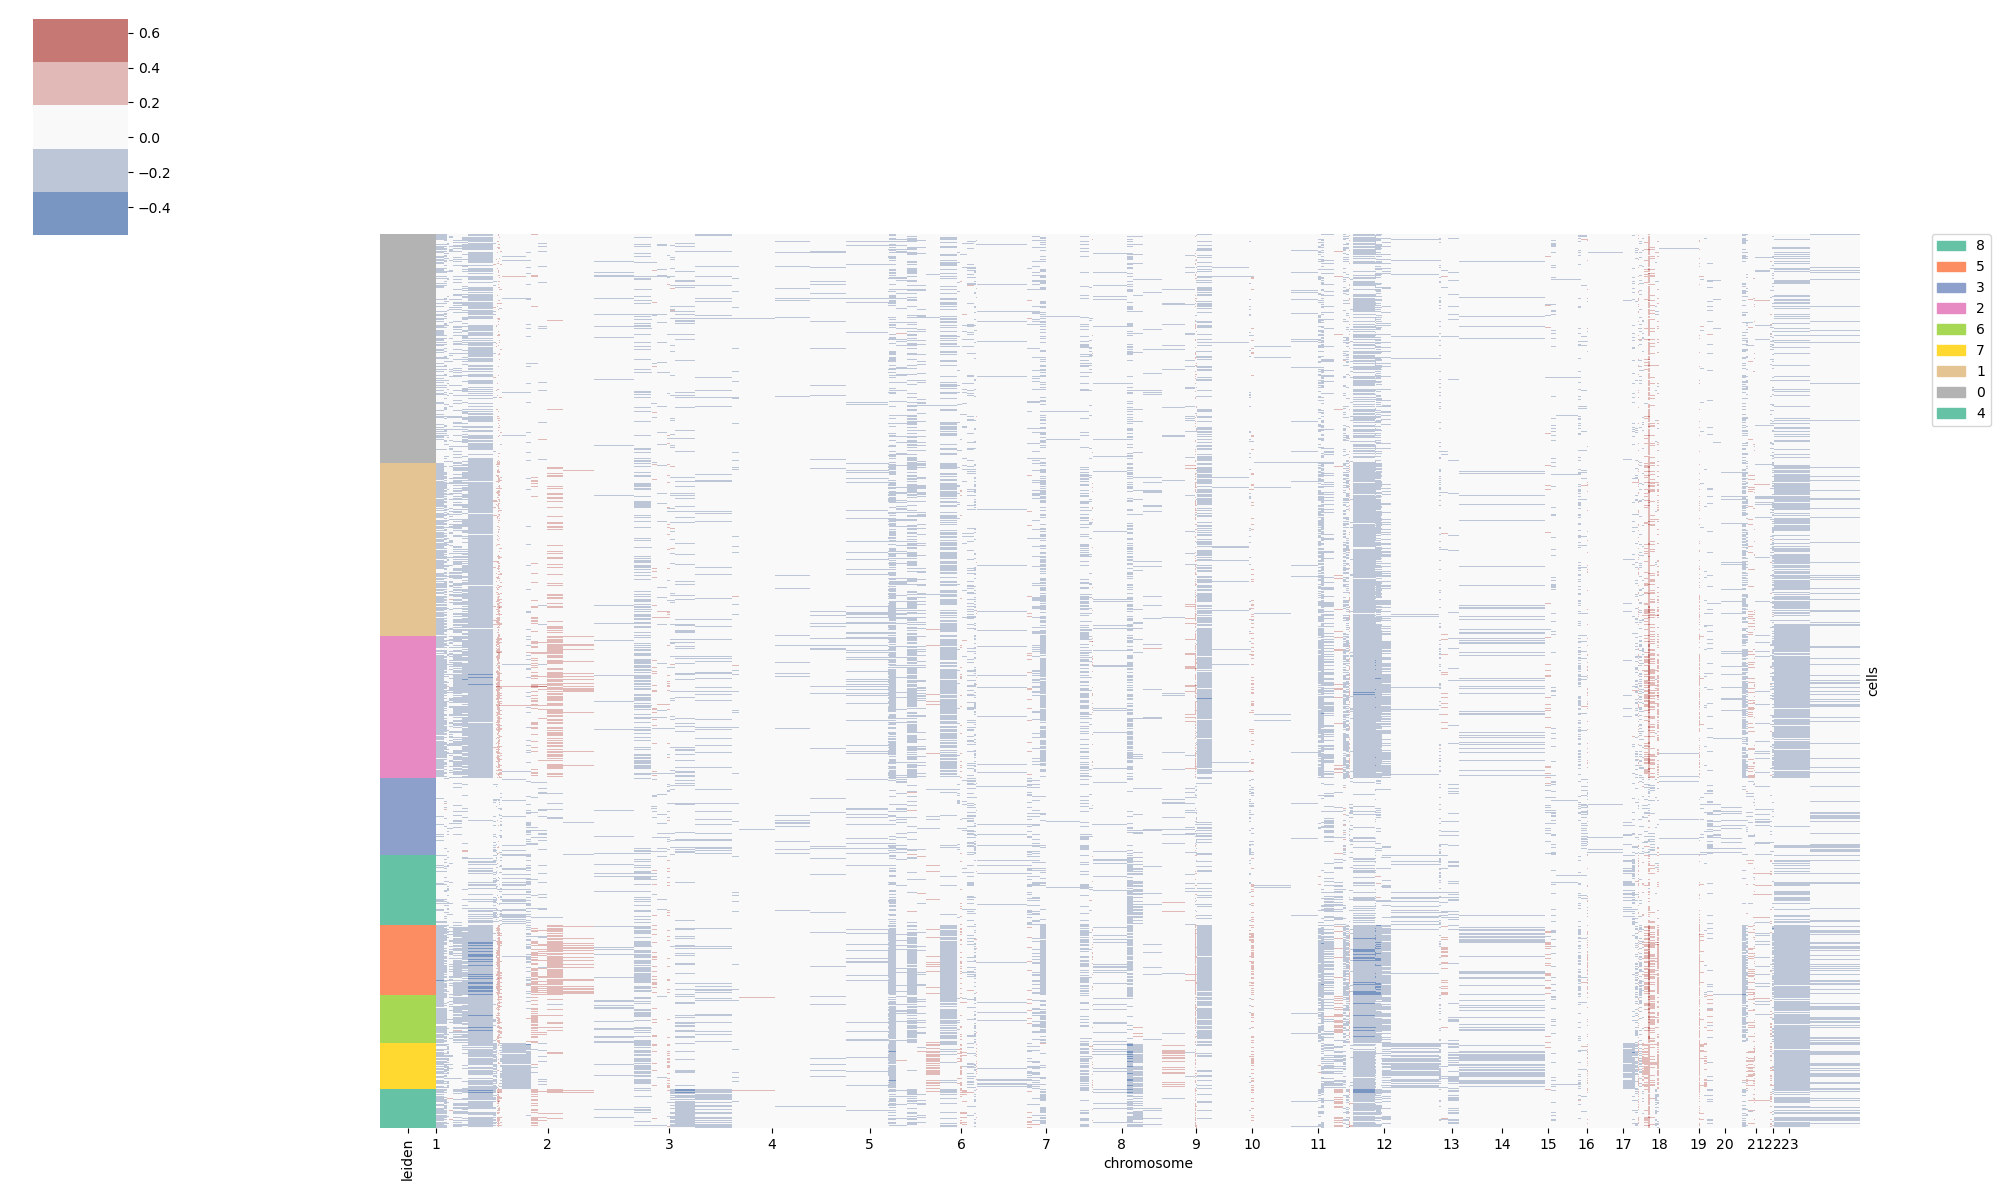

In [79]:
g = sns.clustermap(tmp_sc, row_colors = row_colors_sc, cmap = newcmp, figsize = (19,12), xticklabels = False, yticklabels = False,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("cells")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()

    
handles = [mpatches.Patch(color=lut_sc[key], label=key) for key in lut_sc]
g.ax_heatmap.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [80]:
clones = clones_sc.sort_values().values

In [81]:
cons_sc = []
sc_clone_size = {}
for cl in range(len(set(clones))):
    idx = np.where(clones == cl)[0]
    values = tmp_sc.iloc[idx]
    values = values.median().values
    cons_sc.append(values)
    sc_clone_size[cl] = len(idx)
    

In [82]:
sc_clone_size

{0: 2753, 1: 2073, 2: 1694, 3: 926, 4: 847, 5: 832, 6: 574, 7: 560, 8: 462}

In [83]:
cons_sc = pd.DataFrame(cons_sc, columns = tmp_sc.columns)

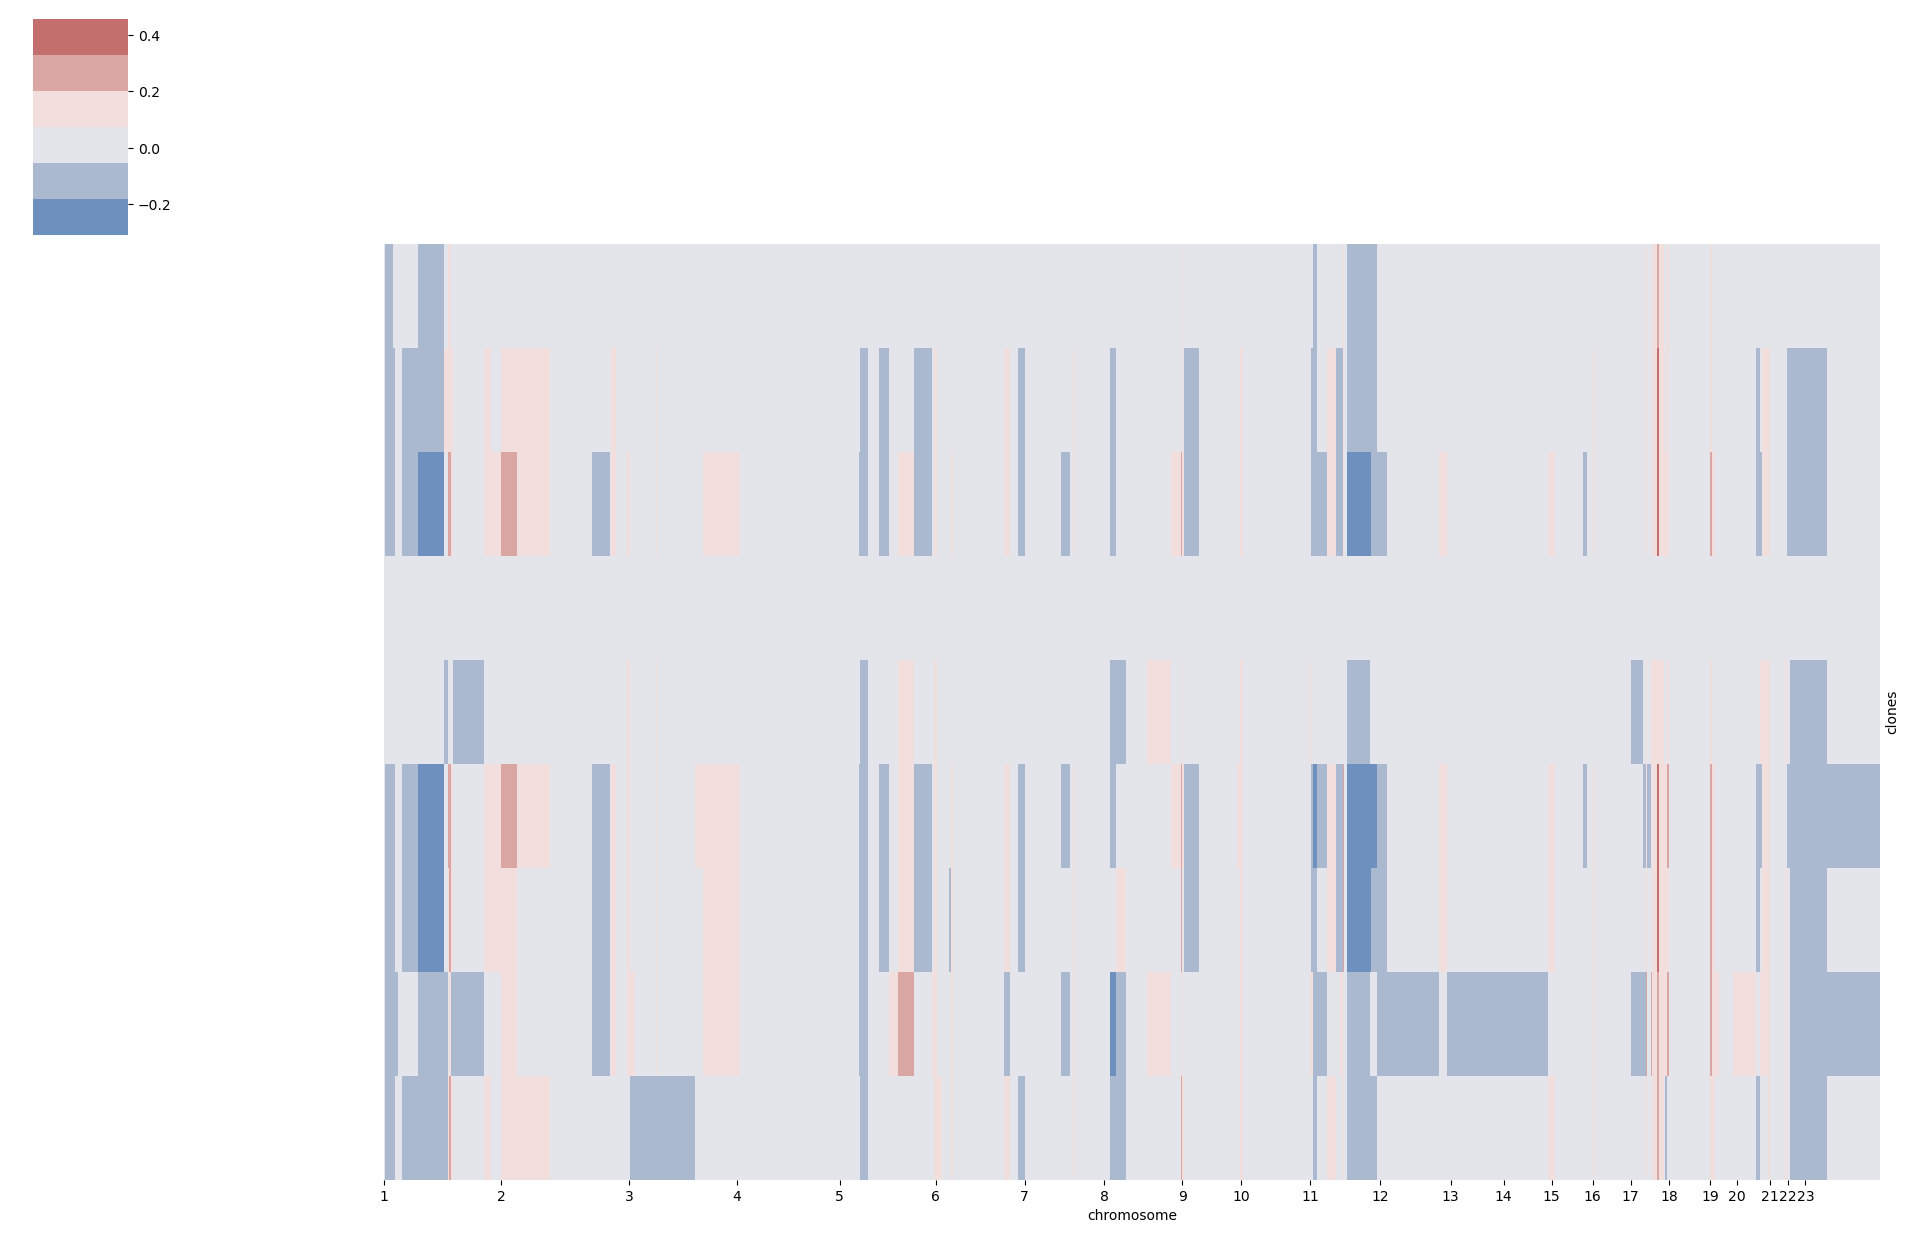

In [84]:

g = sns.clustermap(cons_sc, cmap = sns.color_palette("vlag"), figsize = (19,12), xticklabels = False, yticklabels = False,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()




In [ ]:
cons = cons_sc.T.copy()
diploid_id = cons.columns[-1]+1
cons[diploid_id] = 0
cons = cons.T
n_clusters = cons.shape[0]
X = np.zeros((n_clusters, n_clusters))
for c1 in range(n_clusters):
    cells1 = cons.loc[c1]
    for c2 in range(n_clusters):

        cells2 =  cons.loc[c2]
        dist = np.linalg.norm(cells1-cells2)
        X[c1,c2] = dist
        if c1 != c2 and dist ==0:
            dist = 1e-06
            X[c1,c2] = dist

In [132]:
np.save("../data/interim/clone_dist.npy",1-X/X.max())

array([[1.        , 0.77439763, 0.52347409, 0.65536178, 0.67280636,
        0.2886319 , 0.55667335, 0.3407461 , 0.63728405, 0.68807904],
       [0.77439763, 1.        , 0.74242655, 0.4584098 , 0.55461467,
        0.50053511, 0.71084537, 0.36084372, 0.68769894, 0.47414725],
       [0.52347409, 0.74242655, 1.        , 0.22386834, 0.35686569,
        0.75008355, 0.76737493, 0.30229049, 0.58914126, 0.230789  ],
       [0.65536178, 0.4584098 , 0.22386834, 1.        , 0.61043814,
        0.        , 0.26825281, 0.21674747, 0.40164371, 0.8468873 ],
       [0.67280636, 0.55461467, 0.35686569, 0.61043814, 1.        ,
        0.15560153, 0.39637728, 0.57303908, 0.49269232, 0.63817448],
       [0.2886319 , 0.50053511, 0.75008355, 0.        , 0.15560153,
        1.        , 0.61256215, 0.19545772, 0.4015273 , 0.00698731],
       [0.55667335, 0.71084537, 0.76737493, 0.26825281, 0.39637728,
        0.61256215, 1.        , 0.31353055, 0.62092473, 0.27508909],
       [0.3407461 , 0.36084372, 0.3022904

In [87]:
X = np.tril(X, -1)
X = csr_matrix(X)
Tcsr = minimum_spanning_tree(X)
tree = Tcsr.toarray().astype(int)

In [127]:
tree

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

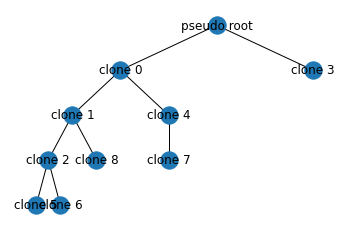

In [88]:
G = nx.Graph()
root = diploid_id

for i in range(np.shape(tree)[0]):
    for j in range(i+1,np.shape(tree)[0]):
        if tree[j,i]>0:
            if i == diploid_id:
                node_i_l = "sudo root"
                node_j_l = f"clone {j}"
            elif j == diploid_id:
                node_j_l = "sudo root"
                node_i_l = f"clone {i}"
            else:
                node_i_l = f"clone {i}"
                node_j_l = f"clone {j}"

            G.add_node(i)
            G.add_node(j)

            G.add_edge(i,j)


#colors = [node_colors.to_dict()[i] for i in G.nodes]
mapping = {x:f"clone {x}" if x !=diploid_id else "pseudo root" for x in G.nodes}
H = nx.relabel_nodes(G, mapping)
pos = hierarchy_pos(H,"pseudo root")  
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw(H,pos, with_labels=True, node_size = 300, ax = ax )

In [126]:
G

In [89]:
dist = distance.cdist(cons_sc, cons_vis, 'euclidean')

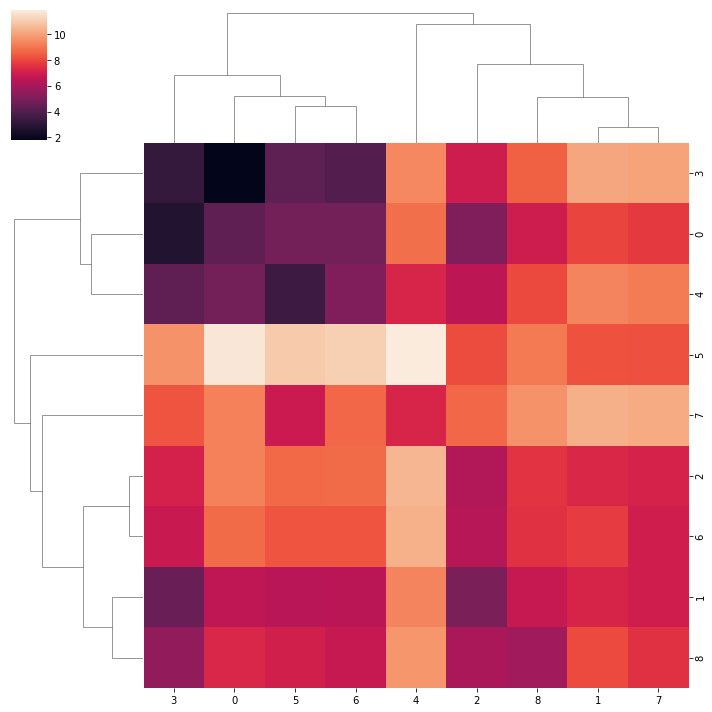

In [90]:
sns.clustermap(dist)

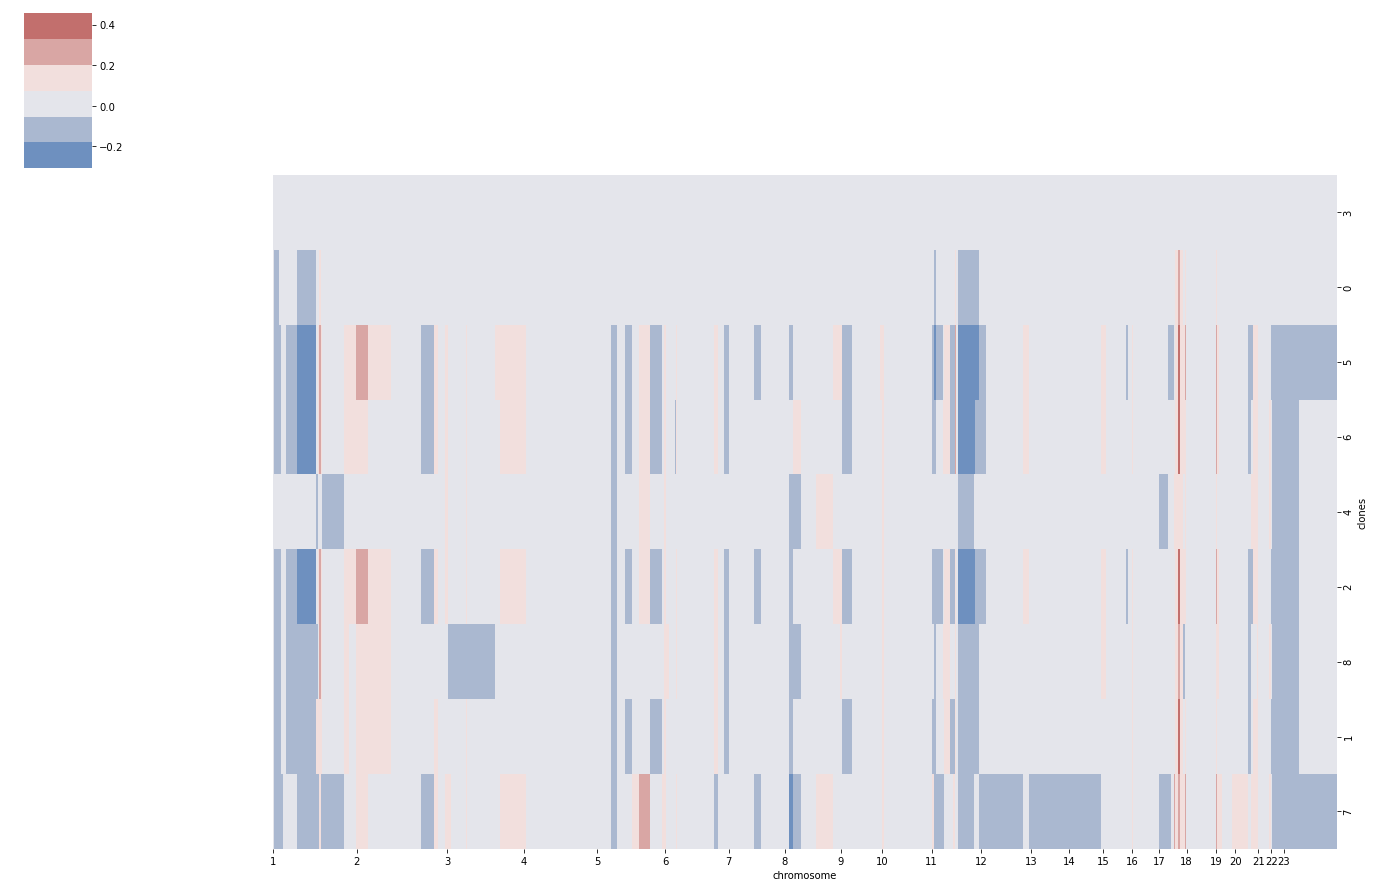

In [91]:

g = sns.clustermap(cons_sc.loc[[3,0,5,6,4,2,8,1,7]], cmap = sns.color_palette("vlag"), figsize = (19,12), xticklabels = False,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()


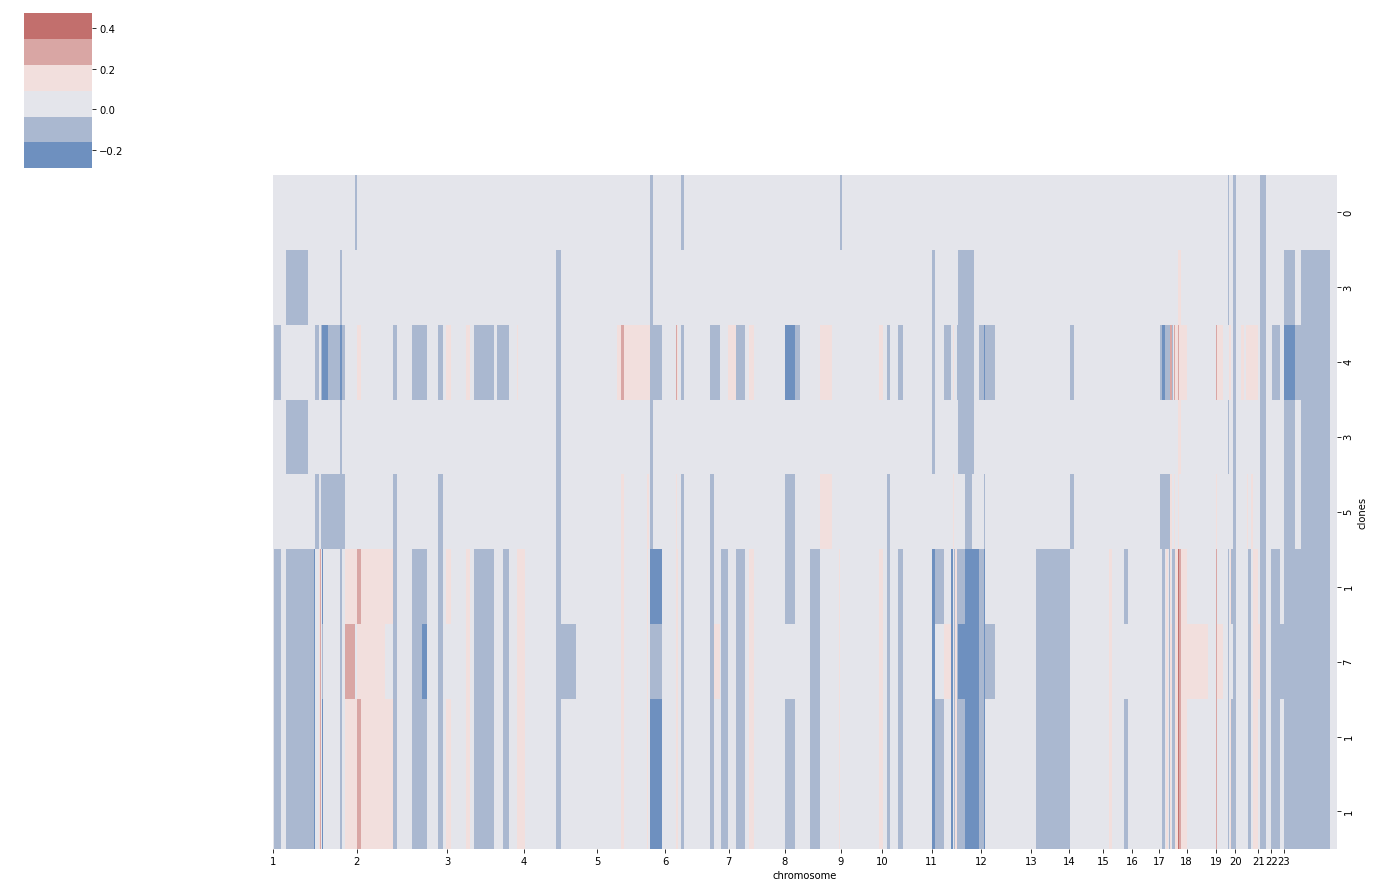

In [92]:
g = sns.clustermap(cons_vis.loc[[0,3,4,3,5,1,7,1,1]], cmap = sns.color_palette("vlag"), figsize = (19,12), xticklabels = False,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()


In [93]:
clones_vis = adata_vis.obs["leiden"]

In [94]:
path = "../data/raw/visium/"
visium = sc.read_visium(path, genome=None, count_file='CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5',
                        library_id=None, load_images=True, source_image_path=None)
visium.var_names_make_unique()

/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [95]:
coor_int = [[int(x[0]),int(x[1])] for x in visium.obsm["spatial"]]
visium.obsm["spatial"] = np.array(coor_int)

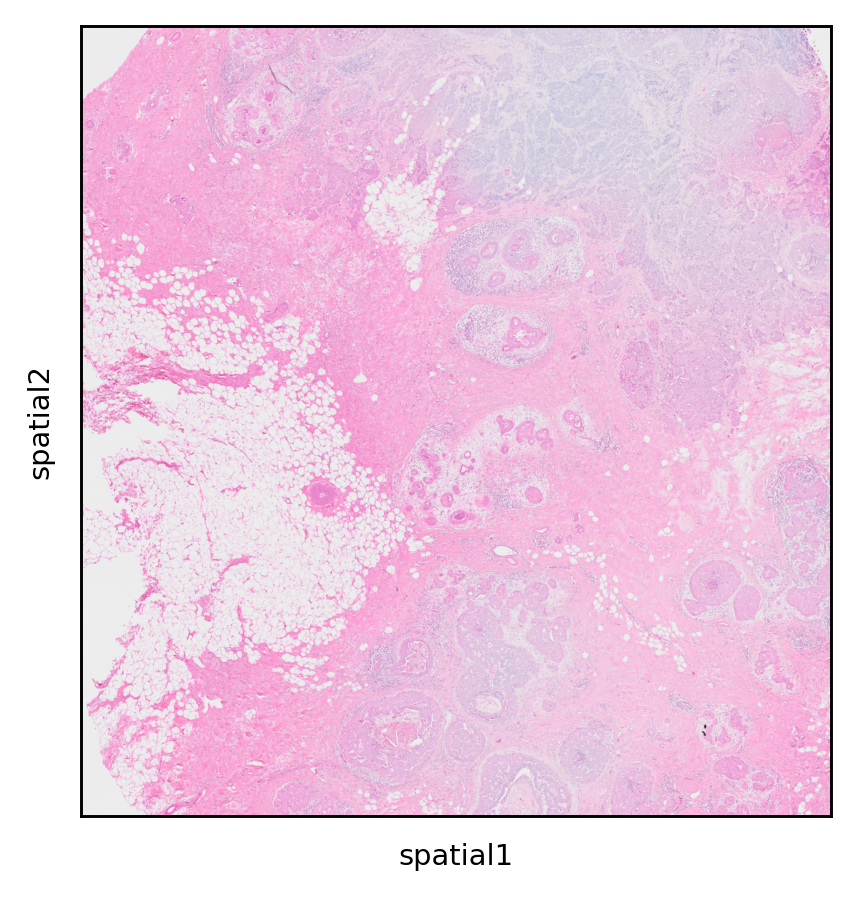

In [96]:
sc.set_figure_params(dpi = 130, scanpy=True, fontsize=8)
sc.pl.spatial(visium)

In [97]:
clones_vis.name = "clone"

In [98]:
clones_vis = clones_vis.astype(str) 

In [100]:
visium.obs = visium.obs.join(clones_vis)
visium.obs["clone"] = visium.obs["clone"].fillna("diploid")


In [124]:
colors = {str(x):lut_vis[x] for x in lut_vis}
colors["diploid"] = '#aec7e8'

In [136]:
colors_sc = {str(x):lut_sc[x] for x in lut_sc}

colors_sc["diploid"]= '#aec7e8'

In [138]:
colors

{'8': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 '4': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 '1': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 '7': (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 '6': (1.0, 0.4980392156862745, 0.0),
 '5': (1.0, 1.0, 0.2),
 '2': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 '3': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 '0': (0.6, 0.6, 0.6),
 'diploid': '#aec7e8'}

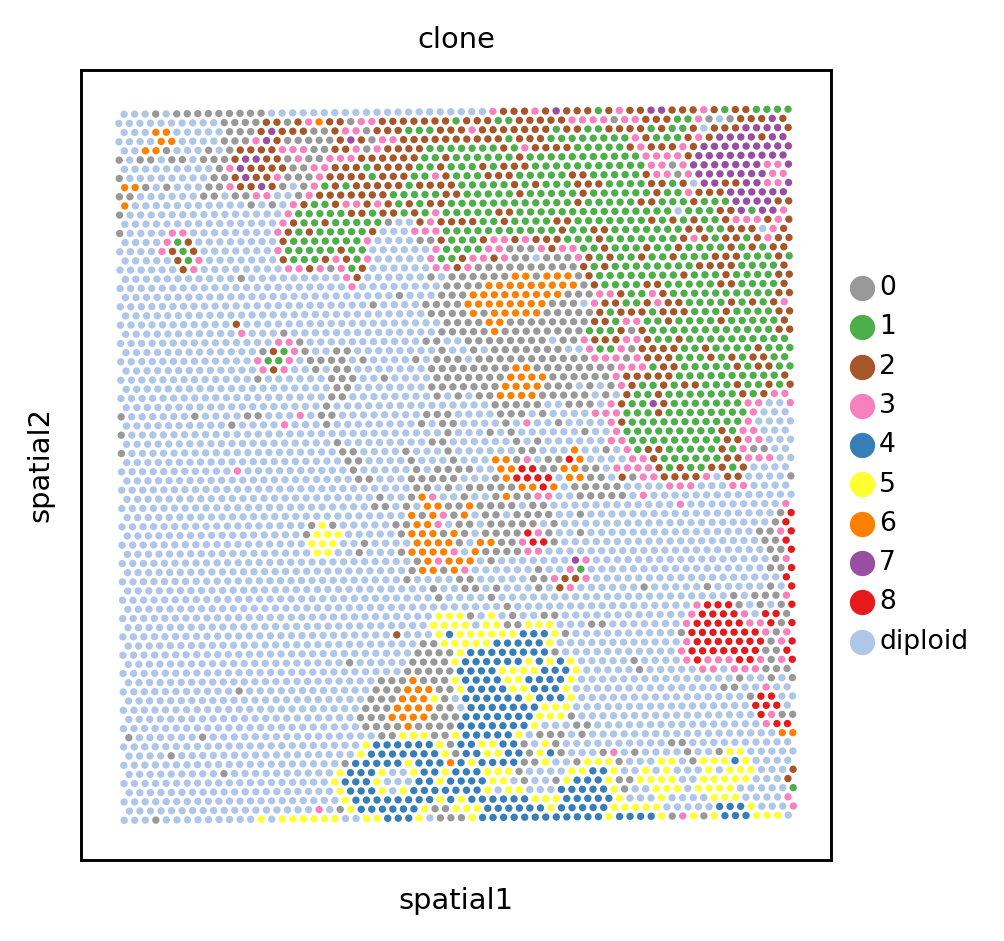

In [125]:
sc.set_figure_params(dpi = 130, scanpy=True, fontsize=8)
sc.pl.spatial(visium, color=["clone"], alpha = 1, bw = False, alpha_img = 0, palette = colors)

In [103]:
adata_vis.obs["leiden"].to_csv("../data/interim/clones_vis.csv")

In [105]:
adata_sc.obs["leiden"].to_csv("../data/interim/clones_sc.csv")

In [106]:
pd.read_csv("../data/interim/clones_sc.csv")

cell.names  leiden
0      CGCAAGGGTTAGTGAG-1       8
1      CAAGACTAGCTTGAGG-1       8
2      GCCAATACATTGCCTG-1       8
3      CTTCAATAGATGATTG-1       8
4      GATGCAAGTATTGCGT-1       8
...                   ...     ...
10716  TCTAACCCAGGTATTG-1       0
10717  TCAACTAGTTAGCGCC-1       3
10718  CAGGTCAAGACCATTT-1       0
10719  TGGTGCGCACCATCCA-1       0
10720  ACAACGGTCTAGTTAC-1       3

[10721 rows x 2 columns]

In [147]:
sc.tl.leiden(adata_sc,key_added= "granular",resolution = 2.5 )



/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


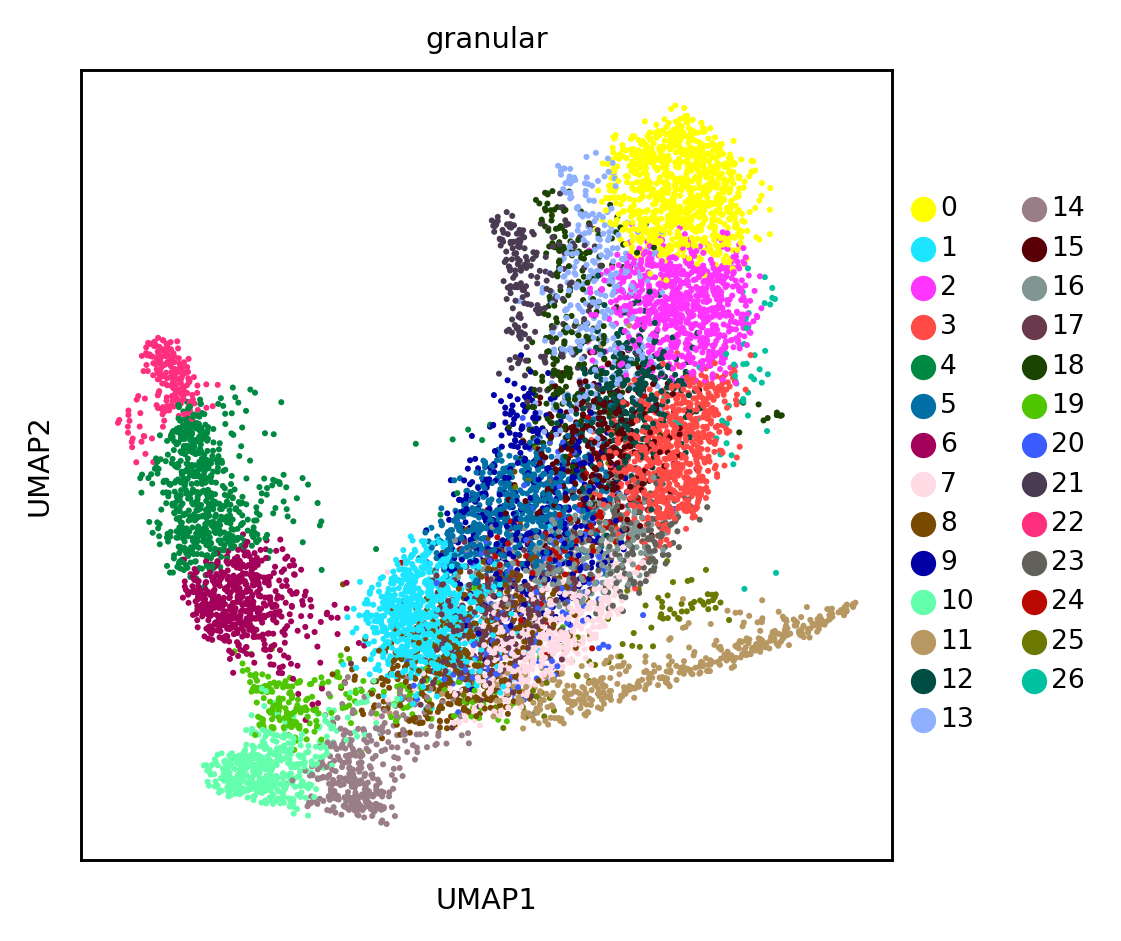

In [148]:
sc.pl.umap(adata_sc, color = "granular")

In [149]:
clones_granular = adata_sc.obs["granular"]

In [150]:
#change data type of clones_vis to int
clones_granular = clones_granular.astype(int)

In [151]:
lut_gr = dict(zip(clones_granular.unique(), sns.color_palette("Blues", len(clones_sc.unique()))))

In [152]:
row_colors_gr = clones_granular.map(lut_gr)

In [153]:
tmp_sc = pd.DataFrame(adata_sc.X)
tmp_sc.index = adata_sc.obs.index


In [154]:
tmp_sc = tmp_sc.loc[clones_granular.sort_values().index]

In [155]:
tmp_sc

0         1         2         3         4       
cell.names                                                             
ACATAGTCATCATCAC-1 -0.082678 -0.082678 -0.082678 -0.082678 -0.160304  \
CTCACCCTCGAACGTG-1 -0.076175 -0.076175 -0.076175 -0.076175 -0.170681   
TGGACAAGTCGAAGTA-1 -0.000246 -0.000246 -0.000246 -0.000246 -0.188448   
TCTAACAGTCATTATG-1  0.063238  0.063238  0.063238  0.063238 -0.185035   
ACCAATCGTGAATCTC-1 -0.133825 -0.133825 -0.133825 -0.133825 -0.207939   
...                      ...       ...       ...       ...       ...   
GTTAATGAGGAACCAT-1  0.018148  0.018148  0.018148  0.018148 -0.106258   
CATTGACGTTGTCAGT-1  0.066226  0.066226  0.066226  0.066226 -0.181501   
GATTGACAGTCAATGA-1 -0.086465 -0.086465 -0.086465 -0.086465 -0.198589   
AGTGATTCAGGTATAT-1 -0.060865 -0.060865 -0.060865 -0.060865 -0.142627   
CGCAAGGGTTAGTGAG-1 -0.358088 -0.358088 -0.358088 -0.358088 -0.338997   

                       5         6         7         8         9      ...   
cell.names                                                            ...   
ACATAGTCATCATCAC-1 -0.160304 -0.160304 -0.160304 -0.160304 -0.160304  ...  \
CTCACCCTCGAACGTG-1 -0.170681 -0.170681 -0.170681 -0.170681 -0.170681  ...   
TGGACAAGTCGAAGTA-1 -0.188448 -0.188448 -0.188448 -0.188448 -0.188448  ...   
TCTAACAGTCATTATG-1 -0.185035 -0.185035 -0.185035 -0.185035 -0.185035  ...   
ACCAATCGTGAATCTC-1 -0.207939 -0.207939 -0.207939 -0.207939 -0.207939  ...   
...                      ...       ...       ...       ...       ...  ...   
GTTAATGAGGAACCAT-1 -0.106258 -0.106258 -0.106258 -0.106258 -0.106258  ...   
CATTGACGTTGTCAGT-1 -0.181501 -0.181501 -0.181501 -0.181501 -0.181501  ...   
GATTGACAGTCAATGA-1 -0.198589 -0.198589 -0.198589 -0.198589 -0.198589  ...   
AGTGATTCAGGTATAT-1 -0.142627 -0.142627 -0.142627 -0.142627 -0.142627  ...   
CGCAAGGGTTAGTGAG-1 -0.338997 -0.338997 -0.338997 -0.338997 -0.338997  ...   

                       12157     12158     12159     12160     12161   
cell.names                                                             
ACATAGTCATCATCAC-1 -0.021174 -0.021174 -0.021174 -0.021174 -0.021174  \
CTCACCCTCGAACGTG-1 -0.064440 -0.064440 -0.064440 -0.064440 -0.064440   
TGGACAAGTCGAAGTA-1 -0.052840 -0.052840 -0.052840 -0.052840 -0.052840   
TCTAACAGTCATTATG-1 -0.050468 -0.050468 -0.050468 -0.050468 -0.050468   
ACCAATCGTGAATCTC-1 -0.099214 -0.099214 -0.099214 -0.099214 -0.099214   
...                      ...       ...       ...       ...       ...   
GTTAATGAGGAACCAT-1 -0.012020 -0.012020 -0.012020 -0.012020 -0.012020   
CATTGACGTTGTCAGT-1 -0.012330 -0.012330 -0.012330 -0.012330 -0.012330   
GATTGACAGTCAATGA-1 -0.012751 -0.012751 -0.012751 -0.012751 -0.012751   
AGTGATTCAGGTATAT-1 -0.015842 -0.015842 -0.015842 -0.015842 -0.015842   
CGCAAGGGTTAGTGAG-1 -0.139933 -0.139933 -0.139933 -0.139933 -0.139933   

                       12162     12163     12164     12165     12166  
cell.names                                                            
ACATAGTCATCATCAC-1 -0.021174 -0.021174 -0.021174 -0.021174 -0.021174  
CTCACCCTCGAACGTG-1 -0.064440 -0.064440 -0.064440 -0.064440 -0.064440  
TGGACAAGTCGAAGTA-1 -0.052840 -0.052840 -0.052840 -0.052840 -0.052840  
TCTAACAGTCATTATG-1 -0.050468 -0.050468 -0.050468 -0.050468 -0.050468  
ACCAATCGTGAATCTC-1 -0.099214 -0.099214 -0.099214 -0.099214 -0.099214  
...                      ...       ...       ...       ...       ...  
GTTAATGAGGAACCAT-1 -0.012020 -0.012020 -0.012020 -0.012020 -0.012020  
CATTGACGTTGTCAGT-1 -0.012330 -0.012330 -0.012330 -0.012330 -0.012330  
GATTGACAGTCAATGA-1 -0.012751 -0.012751 -0.012751 -0.012751 -0.012751  
AGTGATTCAGGTATAT-1 -0.015842 -0.015842 -0.015842 -0.015842 -0.015842  
CGCAAGGGTTAGTGAG-1 -0.139933 -0.139933 -0.139933 -0.139933 -0.139933  

[10721 rows x 12167 columns]

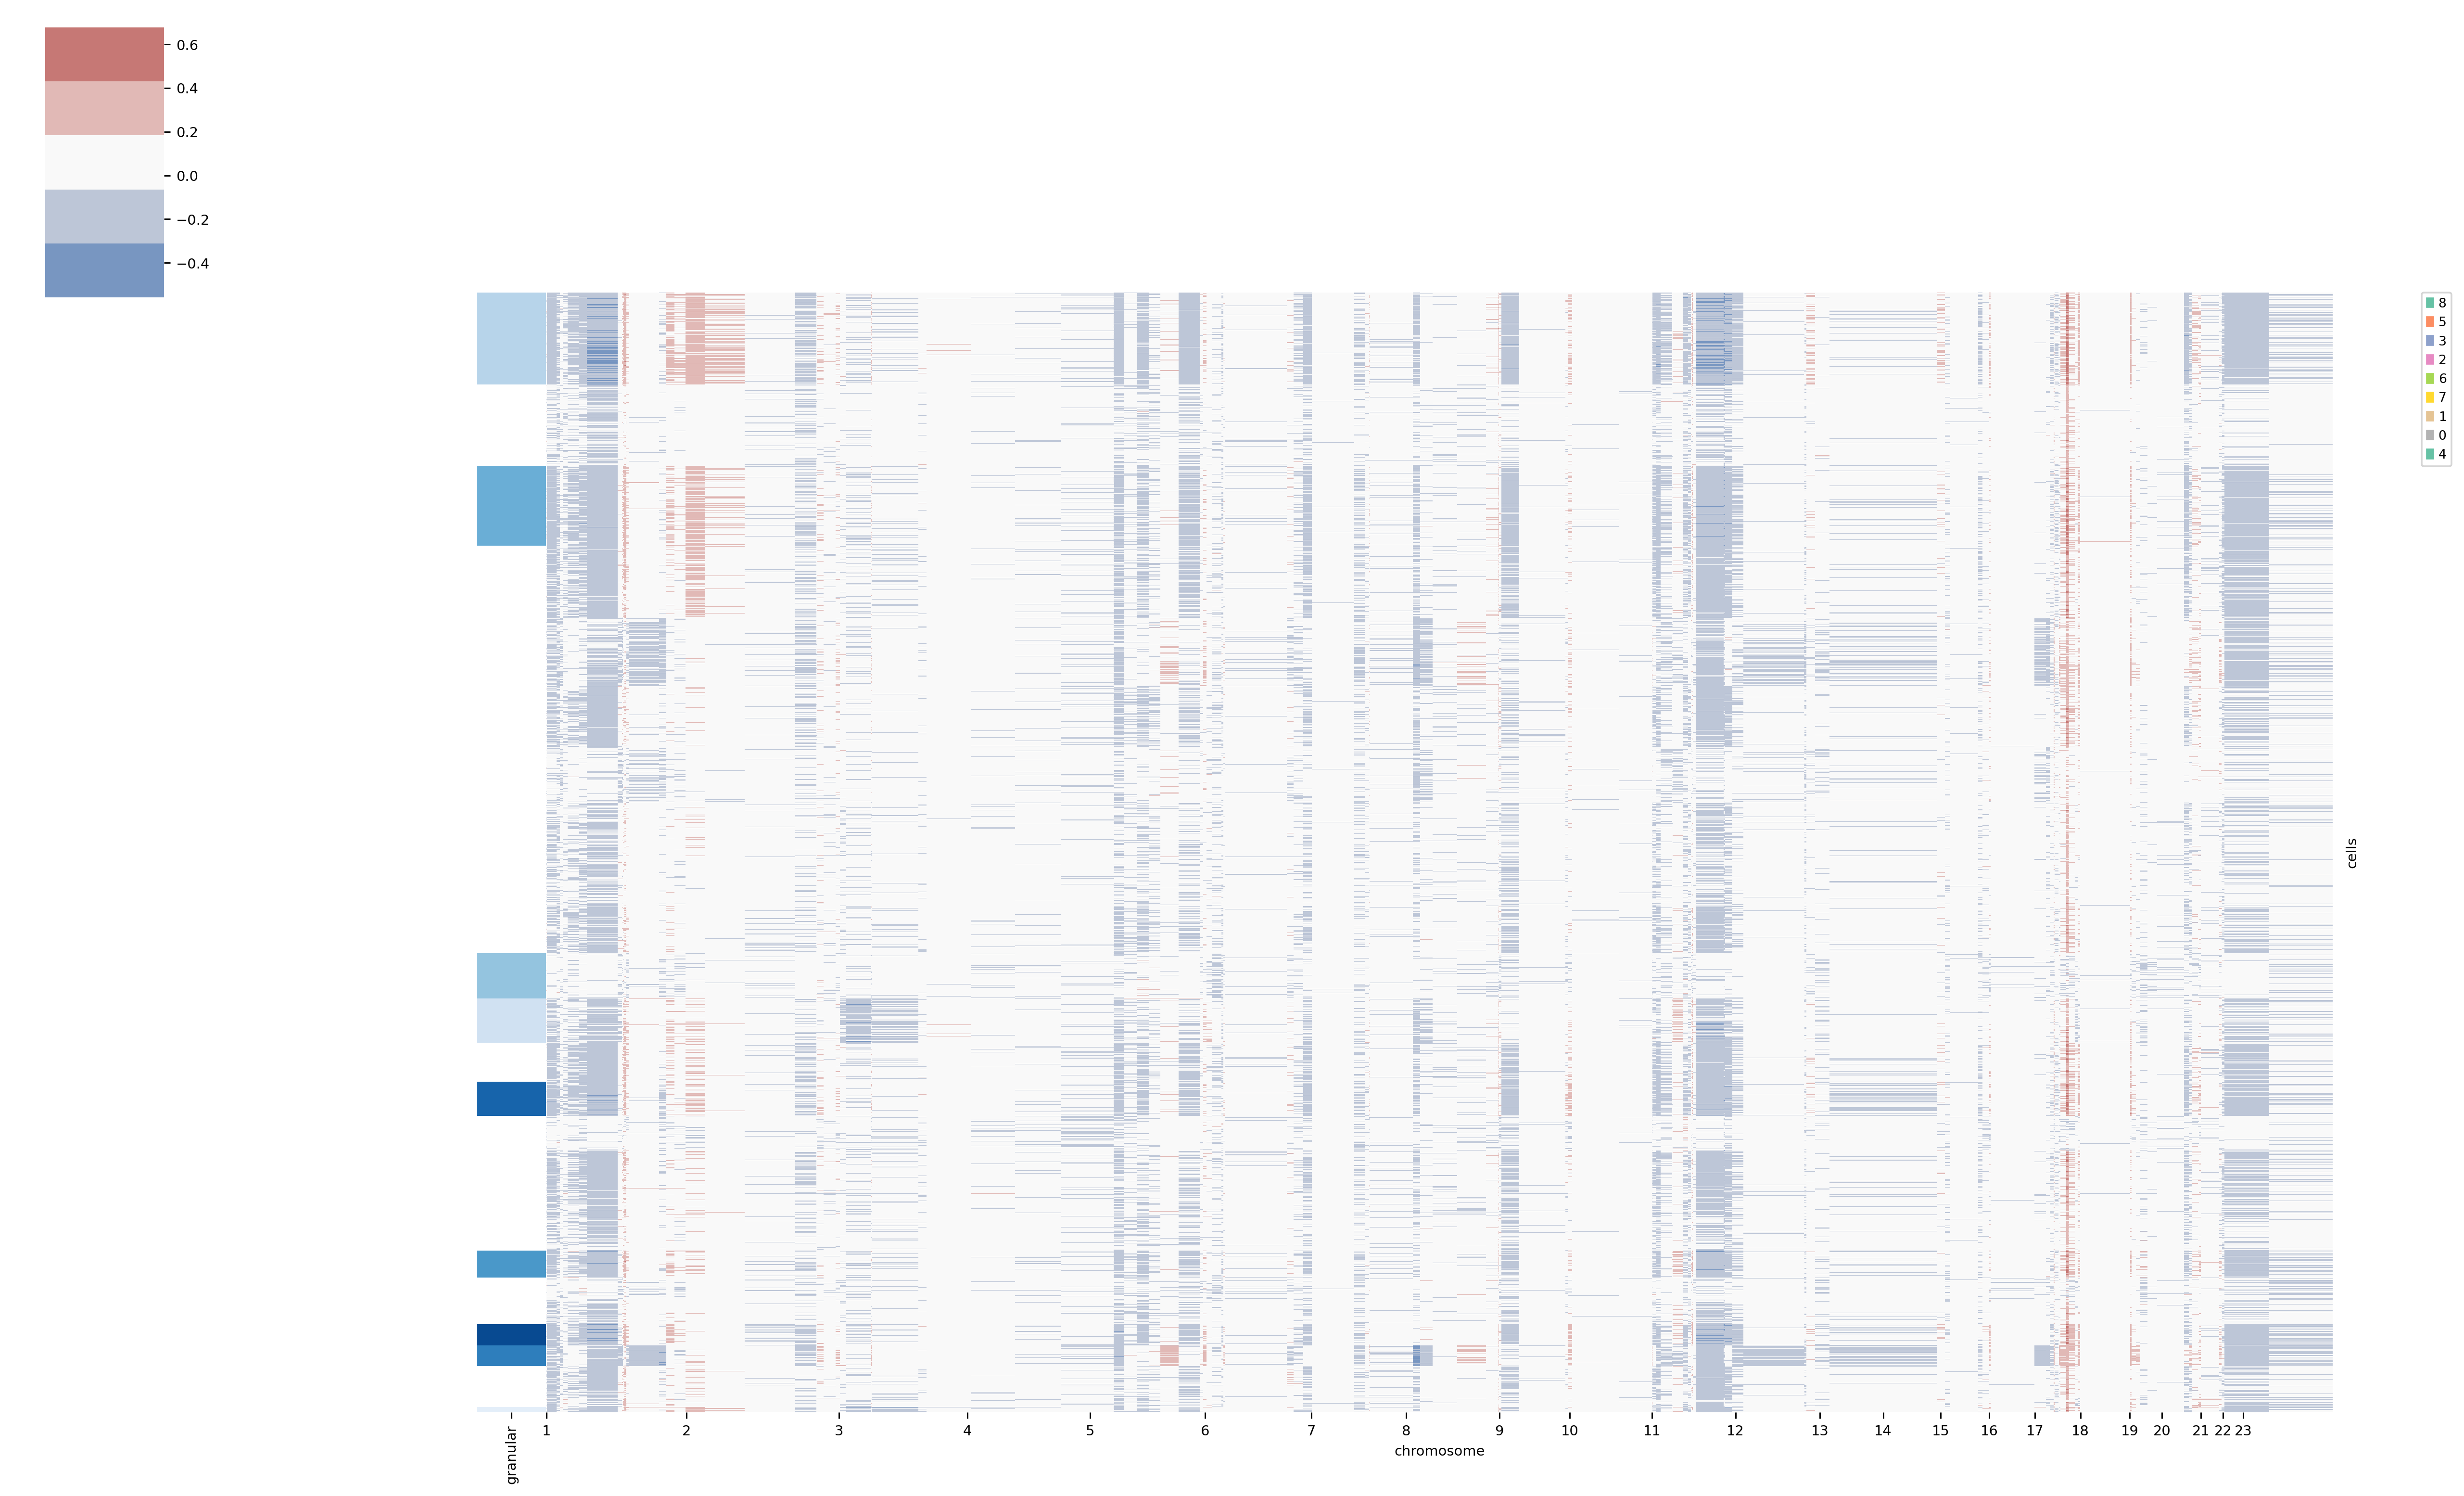

In [156]:
g = sns.clustermap(tmp_sc, row_colors = row_colors_gr, cmap = newcmp, figsize = (19,12), xticklabels = False, yticklabels = False,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("cells")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()

    
handles = [mpatches.Patch(color=lut_sc[key], label=key) for key in lut_sc]
g.ax_heatmap.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [80]:
clones = clones_sc.sort_values().values

In [81]:
cons_sc = []
sc_clone_size = {}
for cl in range(len(set(clones))):
    idx = np.where(clones == cl)[0]
    values = tmp_sc.iloc[idx]
    values = values.median().values
    cons_sc.append(values)
    sc_clone_size[cl] = len(idx)
    

In [82]:
sc_clone_size

{0: 2753, 1: 2073, 2: 1694, 3: 926, 4: 847, 5: 832, 6: 574, 7: 560, 8: 462}

In [83]:
cons_sc = pd.DataFrame(cons_sc, columns = tmp_sc.columns)

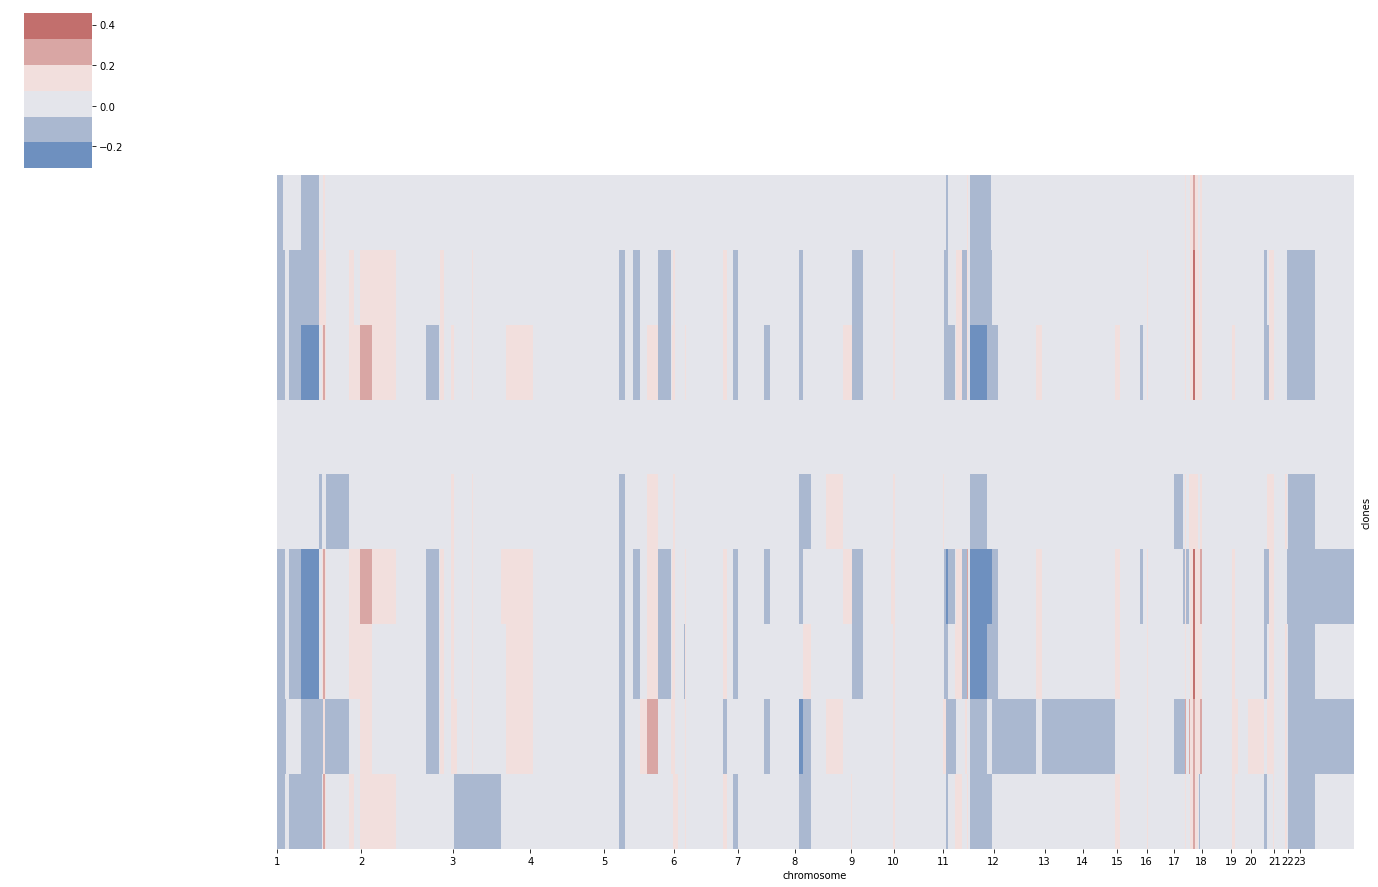

In [84]:

g = sns.clustermap(cons_sc, cmap = sns.color_palette("vlag"), figsize = (19,12), xticklabels = False, yticklabels = False,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()




In [128]:
cons = cons_sc.T.copy()
diploid_id = cons.columns[-1]+1
cons[diploid_id] = 0
cons = cons.T
n_clusters = cons.shape[0]
X = np.zeros((n_clusters, n_clusters))
for c1 in range(n_clusters):
    cells1 = cons.loc[c1]
    for c2 in range(n_clusters):

        cells2 =  cons.loc[c2]
        dist = np.linalg.norm(cells1-cells2)
        X[c1,c2] = dist
        if c1 != c2 and dist ==0:
            dist = 1e-06
            X[c1,c2] = dist

In [132]:
np.save("../data/interim/clone_dist.npy",1-X/X.max())

array([[1.        , 0.77439763, 0.52347409, 0.65536178, 0.67280636,
        0.2886319 , 0.55667335, 0.3407461 , 0.63728405, 0.68807904],
       [0.77439763, 1.        , 0.74242655, 0.4584098 , 0.55461467,
        0.50053511, 0.71084537, 0.36084372, 0.68769894, 0.47414725],
       [0.52347409, 0.74242655, 1.        , 0.22386834, 0.35686569,
        0.75008355, 0.76737493, 0.30229049, 0.58914126, 0.230789  ],
       [0.65536178, 0.4584098 , 0.22386834, 1.        , 0.61043814,
        0.        , 0.26825281, 0.21674747, 0.40164371, 0.8468873 ],
       [0.67280636, 0.55461467, 0.35686569, 0.61043814, 1.        ,
        0.15560153, 0.39637728, 0.57303908, 0.49269232, 0.63817448],
       [0.2886319 , 0.50053511, 0.75008355, 0.        , 0.15560153,
        1.        , 0.61256215, 0.19545772, 0.4015273 , 0.00698731],
       [0.55667335, 0.71084537, 0.76737493, 0.26825281, 0.39637728,
        0.61256215, 1.        , 0.31353055, 0.62092473, 0.27508909],
       [0.3407461 , 0.36084372, 0.3022904

In [87]:
X = np.tril(X, -1)
X = csr_matrix(X)
Tcsr = minimum_spanning_tree(X)
tree = Tcsr.toarray().astype(int)

In [127]:
tree

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

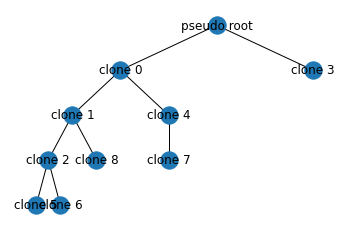

In [88]:
G = nx.Graph()
root = diploid_id

for i in range(np.shape(tree)[0]):
    for j in range(i+1,np.shape(tree)[0]):
        if tree[j,i]>0:
            if i == diploid_id:
                node_i_l = "sudo root"
                node_j_l = f"clone {j}"
            elif j == diploid_id:
                node_j_l = "sudo root"
                node_i_l = f"clone {i}"
            else:
                node_i_l = f"clone {i}"
                node_j_l = f"clone {j}"

            G.add_node(i)
            G.add_node(j)

            G.add_edge(i,j)


#colors = [node_colors.to_dict()[i] for i in G.nodes]
mapping = {x:f"clone {x}" if x !=diploid_id else "pseudo root" for x in G.nodes}
H = nx.relabel_nodes(G, mapping)
pos = hierarchy_pos(H,"pseudo root")  
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw(H,pos, with_labels=True, node_size = 300, ax = ax )